In [1]:
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

import pandas as pd 
import numpy as np 
import re
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import train_test_split
from dir import *
from VAE_models.VAE_model import *
from VAE_models.VAE_model_enhanced import *
from VAE_models.VAE_model_2 import *
from VAE_models.VAE_model_single import *
from training import *
from extras import *
from sklearn.decomposition import PCA

plt.style.use('ggplot')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
print(f"Current working directory: {current_dir}")
print(f"Parent directory: {parent_dir}")

Current working directory: /Users/anastasiiashcherbakova/git_projects/masters_project/large_dataset_new_loss
Parent directory: /Users/anastasiiashcherbakova/git_projects/masters_project


# Contents:
#### - [1) Data exploration](#data_exploration)
[1.1) General data exploration](#general_exploration)
[1.2) PCA](#general_exploration)
#### - [2) Data preprocessing](#data_preprocessing)
[2.1) Dataset preprocessing](#dataset_preprocessing)
[2.2) Conversing the dataset into splits and dataloaders](#dataloaders)
#### - [3) Essential genes manipulatioins](#essential)
#### - [4) Training of full dataset (train_full_dataset.py script on the CS account)](#training)
[4.1) Full dataset (base model and enhanced model)](#full_dataset)

<a id='data_exploration'></a>
# 1) Data exploration 

<a id='general_exploration'></a>
## 1.1) General data exploration

In [3]:
essential_genes = pd.read_csv(PAPER_ESSENTIAL_GENES)

In [4]:
large_data = pd.read_csv(TEN_K_DATASET, index_col=[0], header=[0])

In [5]:
# Turning all sample names uppercase
large_data.columns = large_data.columns.str.upper()

In [6]:
large_data

,41004_G02_CONTIGS_PACBIO,50884_F01_CONTIGS_PACBIO,AIAW00000000,AIBY00000000,AIFN00000000,NC_002655,NC_002695,NC_011353,NC_013008,NC_017906,...,ESC_PA2010AA_AS,ESC_PA2013AA_AS,ESC_PA2014AA_AS,ESC_PA2016AA_AS,ESC_PA2019AA_AS,ESC_PA2021AA_AS,ESC_PA2023AA_AS,ESC_PA2315AA_AS,ESC_RA2551AA_AS,ESC_RA2561AA_AS
Strain,,,,,,,,,,,,,,,,,,,,,
Lineage,1,1,1,1,1,1,1,1,1,1,...,51,51,51,51,51,51,51,51,51,51
group_5501,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
group_4783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
group_4456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
group_6055,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
group_2149_7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
group_2067_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
group_2068_8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
large_data.sum(axis=1).sort_values()

Strain
group_569           1
group_4401_2        1
group_5102          1
group_5100_2        1
group_5099_3        1
                ...  
hldD             7512
group_4462_2     7512
grxC             7512
diaA             7512
Lineage         55565
Length: 55040, dtype: int64

In [8]:
sum(large_data.sum(axis=0) < 4000)

10

In [9]:
phylogroup_data = pd.read_csv(TEN_K_DATASET_PHYLOGROUPS, index_col=[0], header=[0])

In [10]:
phylogroup_data

,Phylogroup
ID,
ESC_CA4458AA_AS,E
ESC_CA5810AA_AS,E
11657_7#79,B2
ESC_SA7073AA_AS,B1
SRS3528668,Not Determined
...,...
39111_C02,Not determined
ESC_SA2343AA_AS,E
ESC_SA2344AA_AS,E


In [11]:
phylogroup_data.value_counts()

Phylogroup    
E                 3428
B2                2311
Not Determined    1708
B1                1535
D                  345
A                  335
Not determined     232
F                  157
Shigella            67
C                   28
Name: count, dtype: int64

In [12]:
data_without_lineage = large_data.drop(index=['Lineage'])
large_data_t = np.array(data_without_lineage.transpose())

print(f"Full dataset shape: {large_data_t.shape}")


Full dataset shape: (7512, 55039)


In [13]:
threshold_data = []
thresholds = np.linspace(0, 50, num=50)
data_without_lineage = large_data.drop(index=['Lineage'])

for i in thresholds:
    row_sums = data_without_lineage.sum(axis=1)
    threshold_data.append(len(data_without_lineage[row_sums >= i]))


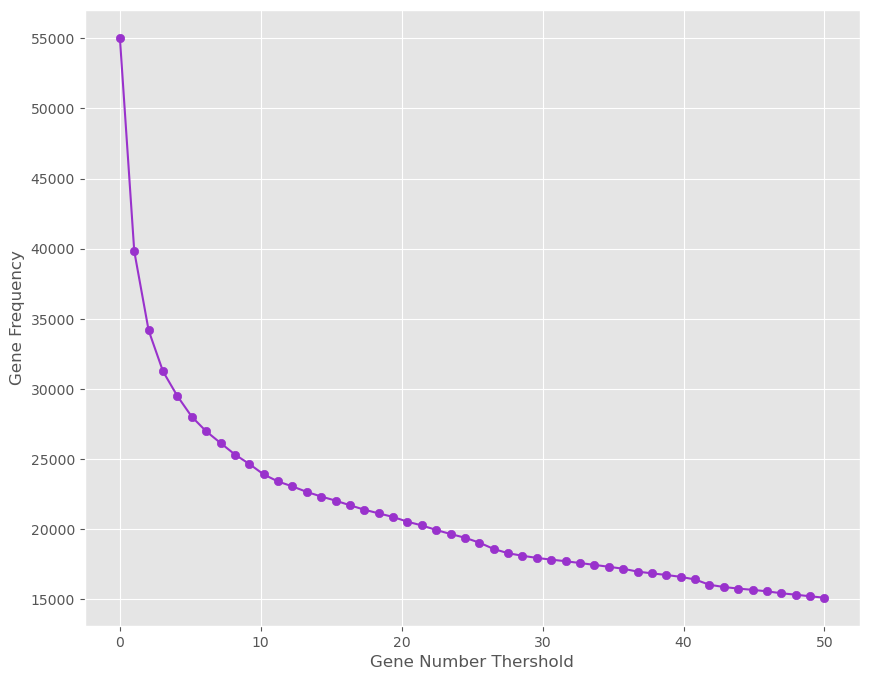

In [14]:
plt.figure(figsize=(10,8))
plt.scatter(thresholds, threshold_data, color='darkorchid')
plt.plot(thresholds, threshold_data, color='darkorchid')
plt.xlabel("Gene Number Thershold")
plt.ylabel("Gene Frequency")
# plt.savefig("figures/gene_frequency_2.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [15]:
gene_count_frequency = data_without_lineage.sum(axis=1)
mean = np.mean(gene_count_frequency)
median = np.median(gene_count_frequency)
min_value = np.min(gene_count_frequency)
max_value = np.max(gene_count_frequency)

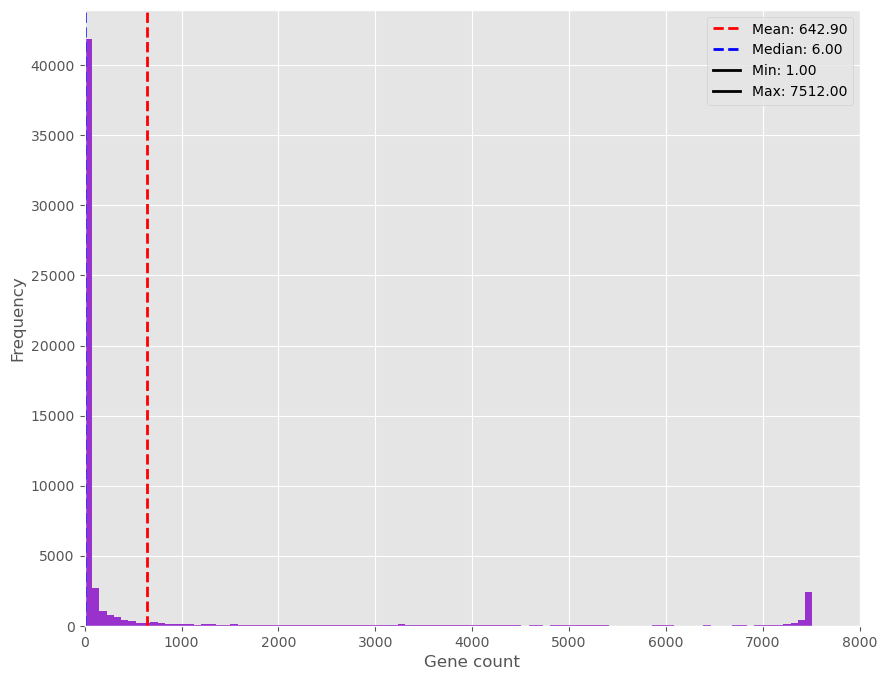

In [16]:
plt.figure(figsize=(10,8))
plt.hist(gene_count_frequency, color='darkorchid', bins=100)
plt.xlim(0, 8000)
plt.xlabel('Gene count')
plt.ylabel('Frequency')
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='b', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')
dummy_min = plt.Line2D([], [], color='black',  linewidth=2, label=f'Min: {min_value:.2f}')
dummy_max = plt.Line2D([], [], color='black', linewidth=2, label=f'Max: {max_value:.2f}')

handles = [plt.Line2D([], [], color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}'),
        plt.Line2D([], [], color='b', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}'),
        dummy_min, dummy_max]
plt.legend(handles=handles)
# plt.savefig("figures/gene_count_2.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [17]:
genome_size_frequency = data_without_lineage.sum(0)
mean = np.mean(genome_size_frequency)
median = np.median(genome_size_frequency)
min_value = np.min(genome_size_frequency)
max_value = np.max(genome_size_frequency)

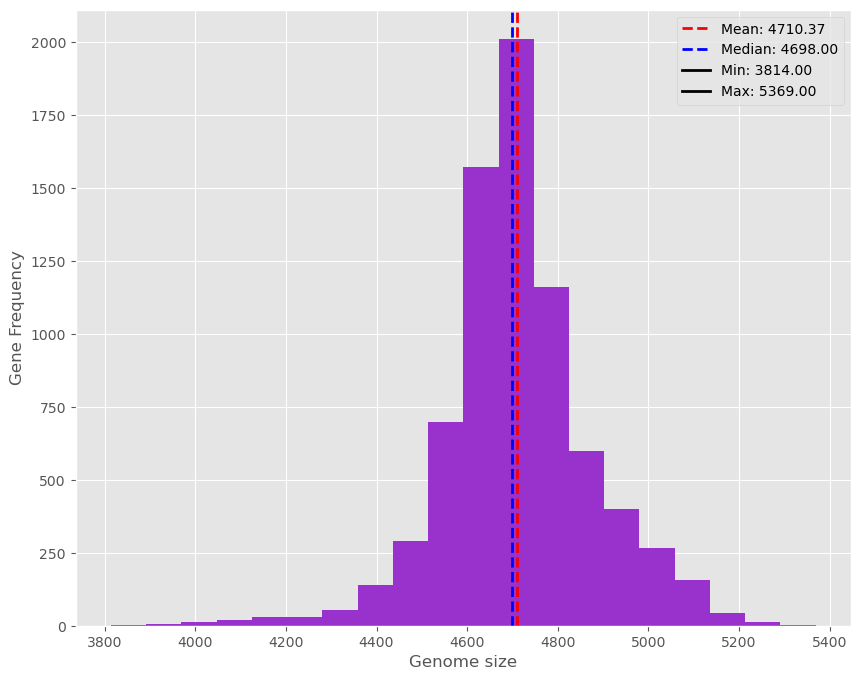

In [18]:
plt.figure(figsize=(10,8))
plt.hist(genome_size_frequency, bins=20, color='darkorchid')
plt.xlabel('Genome size')
plt.ylabel('Gene Frequency')
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='b', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')
dummy_min = plt.Line2D([], [], color='black',  linewidth=2, label=f'Min: {min_value:.2f}')
dummy_max = plt.Line2D([], [], color='black', linewidth=2, label=f'Max: {max_value:.2f}')

handles = [plt.Line2D([], [], color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}'),
        plt.Line2D([], [], color='b', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}'),
        dummy_min, dummy_max]
plt.legend(handles=handles)
plt.show()

In [19]:
print(f"Smallest genome: {large_data.sum(0).min()}")

Smallest genome: 3838


## 1.2) PCA

In [20]:
# Inner merge dataset
merged_df = pd.merge(data_without_lineage.transpose(), phylogroup_data, how='inner', left_index=True, right_on='ID')

In [21]:
merged_df

,group_5501,group_4783,group_4456,group_6055,group_2859,group_3832,group_4223,group_2401,group_1236,group_3245,...,group_2066_1,mukF_1,group_955_2,group_1382_5,group_2149_7,group_2067_4,group_2068_8,group_2069_3,group_2071_4,Phylogroup
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
AIBY00000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
AIFN00000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
NC_002655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
NC_002695,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,D
ESC_PA2023AA_AS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,D
ESC_PA2315AA_AS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,D


In [22]:
print(f"merged dataset shape: {merged_df.shape}")

merged dataset shape: (5953, 55040)


In [23]:
merged_df.iloc[:, :-1]

,group_5501,group_4783,group_4456,group_6055,group_2859,group_3832,group_4223,group_2401,group_1236,group_3245,...,group_1609_5,group_2066_1,mukF_1,group_955_2,group_1382_5,group_2149_7,group_2067_4,group_2068_8,group_2069_3,group_2071_4
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AIBY00000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AIFN00000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NC_002655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NC_002695,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ESC_PA2023AA_AS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ESC_PA2315AA_AS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
all_genes = merged_df.columns # all genes and phylogroup

In [25]:
merged_df['Phylogroup'].value_counts()

Phylogroup
E           2496
B2          1982
B1           877
D            299
A            111
F            102
Shigella      63
C             23
Name: count, dtype: int64

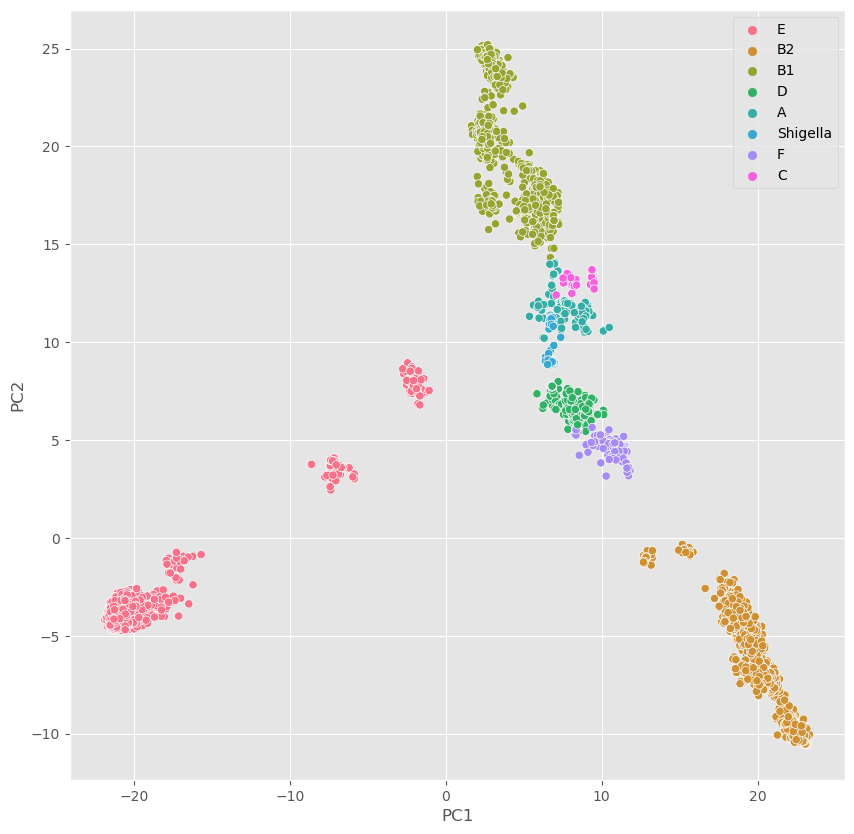

In [26]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(merged_df.iloc[:, :-1])
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])

plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = merged_df.Phylogroup.tolist(), data=df_pca)
# plt.savefig("figures/PCA_graph_BD_Phylogroup.pdf", format="pdf", bbox_inches="tight")
plt.show()

# 2) Data preprocessing

## 2.1) Dataset preprocessing 

In [27]:
data_array_t = np.array(merged_df.iloc[:, :-1])
phylogroups_array = np.array(merged_df.iloc[:, -1])

In [28]:
print("Checking dataset shapes")
print(f"Values array: {data_array_t.shape}")
print(f"Phylogroups array: {phylogroups_array.shape}")

Checking dataset shapes
Values array: (5953, 55039)
Phylogroups array: (5953,)


## 2.2) Conversing the dataset into splits and dataloaders

In [29]:
# Convert to PyTorch tensor
data_tensor = torch.tensor(data_array_t, dtype=torch.float32)

# Split into train and test sets
train_data, temp_data, train_labels, temp_labels = train_test_split(data_tensor, phylogroups_array, test_size=0.3, random_state=12345)
val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.3333, random_state=12345)
test_phylogroups = test_labels

# Set batch size
batch_size = 32

# TensorDataset
train_dataset = TensorDataset(train_data)
val_dataset = TensorDataset(val_data)
test_dataset = TensorDataset(test_data)

# Set laoders
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [30]:
print(f"Train data shape {train_data.shape}")
print(f"Test data shape {test_data.shape}")
print(f"Val data shape {val_data.shape}")

Train data shape torch.Size([4167, 55039])
Test data shape torch.Size([596, 55039])
Val data shape torch.Size([1190, 55039])


# 3) Essential genes manipulatioins

In [31]:
# Creating an array of essential genes fromt the paper and flattening it 
essential_genes_array = np.array(essential_genes).flatten()

In [32]:
print(f"Total number of essential genes present in the paper: {len(essential_genes_array)}")

Total number of essential genes present in the paper: 358


In [33]:
# Creating a gene mask for the essential arrays for more optimal counting of the essential arrays present in the samples 
essential_genes_mask = np.isin(all_genes, essential_genes_array)

In [34]:
print(f"Total number of essential genes present in the dataset: {np.sum(essential_genes_mask)}")

Total number of essential genes present in the dataset: 316


In [35]:
# figuring out which genes are not present in the dataset
subset_not_in_essential_genes_mask = essential_genes[~np.isin(np.array(essential_genes), np.array(all_genes[essential_genes_mask]))]

In [36]:
# figuring out which genes are not present in the dataset
subset_in_essential_genes_mask = essential_genes[np.isin(np.array(essential_genes), np.array(all_genes[essential_genes_mask]))]

In [37]:
absent_genes = np.array(subset_not_in_essential_genes_mask).flatten()

In [38]:
print(f"Number of genes not present in the dataset: {len(absent_genes)}")

Number of genes not present in the dataset: 42


In [39]:
present_genes = np.array(subset_in_essential_genes_mask).flatten()

In [40]:
print(f"Number of genes present in the dataset: {len(present_genes)}") 

Number of genes present in the dataset: 316


In [41]:
# Seeing if the genes split into multiple parts are the essential genes 
matched_columns = []

for gene in absent_genes:
    pattern = re.compile(f"{gene}")
    matches = [col for col in merged_df.columns if pattern.match(col) and col not in present_genes]
    matched_columns.extend(matches)


divided_genes = np.array(matched_columns)
print(divided_genes)
print(len(divided_genes))


['msbA_2' 'msbA_1' 'msbA_3' 'fabG_2' 'fabG_1' 'fabG_3' 'fabG_1_1'
 'fabG_2_1' 'fabG_4' 'fabG_4_1' 'fabG_2_2' 'fabG2' 'fabG_2_3' 'lolD_2'
 'lolD_1' 'lolD_3' 'lolD_3_1' 'lolD_4' 'topA_3' 'topA_3_1' 'topA_2'
 'topA_1' 'topA_3_2' 'metG_2' 'metG_2_1' 'metG_2_2' 'fbaA_2' 'fbaA_1'
 'fbaA_3' 'fbaA_3_1' 'fbaA_1_1' 'higA_3' 'higA-1' 'higA1' 'higA1_1'
 'higA_1' 'higA_3_1' 'higA_1_1' 'higA_3_2' 'higA1_2' 'higA_2' 'higA1_3'
 'higA-2' 'higA_2_1' 'lptB_1' 'lptB_1_1' 'ssbA' 'ssb_1' 'ssb_1_1' 'ssb_2'
 'ssb_4' 'ssb_2_1' 'ssb_2_2' 'ssb_1_2' 'ssb_1_3' 'ssb_5' 'ssbA_1' 'lptG_1'
 'lptG_2' 'lptG_3' 'lptG_2_1' 'lptG_1_1' 'dnaC_3' 'dnaC_1' 'dnaC_2'
 'dnaC_1_1' 'dnaC_1_2' 'dnaC_1_3' 'dnaC_1_4' 'dnaC_1_5' 'dnaC_2_1'
 'dnaC_1_6' 'dnaC_2_2']
73


In [42]:
# Manually creating the array of genes which is divided into chunks
divided_genes_prefixes = ['msbA', 'fabG', 'lolD', 'topA', 'metG', 'fbaA', 'higA', 'lptB', 'ssb',  'lptG', 'dnaC'] # 'higA-1', 'higA1','higA-2', 'ssbA' dont count 

In [43]:
not_present = np.array(list(set(absent_genes) - set(divided_genes_prefixes)))

In [44]:
print(f"Genes which are still not present in the dataset after prefix extraction: {not_present}:")
print(f"Total number: {len(not_present)}:")

Genes which are still not present in the dataset after prefix extraction: ['ydcD' 'dfp' 'yqeL' 'ynbG' 'ymfE' 'ygeF' 'pheM' 'ygeG' 'dicA' 'cohE'
 'ydaS' 'yedN' 'trpL' 'ygeN' 'yddL' 'cydX' 'ydaE' 'ydhL' 'ycaR' 'cydC'
 'ymiB' 'ispU' 'ykfM' 'yciS' 'yihA' 'ttcC' 'racR' 'yobI' 'yjbS' 'yncH'
 'yffS']:
Total number: 31:


In [45]:
# Creating a new array of the unique genes presetn in the dataset (single name + divided into chunks genes)
# print("New total number of the genes present in the dataset: ", np.concatenate(present_genes, divided_genes_prefixes))

In [46]:
# Creating a new array of the genes () both sigle name and didived) presetn in the dataset 
combined_array = np.concatenate((present_genes, divided_genes))

In [47]:
len(combined_array)

389

In [48]:
# Creating a new gene mask including the divided essential genes 
essential_genes_mask = np.isin(all_genes, combined_array)

In [49]:
essential_genes_df = merged_df.loc[:, essential_genes_mask].copy()

In [50]:
essential_genes_df

,higA_3,topA_3,higA-1,dnaC_3,higA1,ssbA,fbaA_2,holB,metG_2,relB,...,higA-2,lptG_2_1,ssb_1_3,topA_3_2,ssb_5,ssbA_1,metG_2_2,dnaC_2_2,higA_2_1,lptG_1_1
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
AIBY00000000,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
AIFN00000000,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
NC_002655,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
NC_002695,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
ESC_PA2023AA_AS,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
ESC_PA2315AA_AS,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
gene_sums = essential_genes_df.sum()
zero_sum_genes = gene_sums[gene_sums == 0].index.tolist()
print(zero_sum_genes)
print(len(zero_sum_genes))

['dnaC_1_3', 'ssb_1_2', 'lptG_2_1']
3


Dataframe of just absent essential genes (including the ones that are split up)

In [52]:
absent_essential_genes_df = pd.DataFrame()

for prefix in absent_genes:
    cols_to_merge = essential_genes_df.filter(regex=f'^{prefix}')
    absent_essential_genes_df[prefix] = (cols_to_merge.sum(axis=1) > 0).astype(int)

In [53]:
absent_essential_genes_df

,ispU,ykfM,cydX,cydC,msbA,ycaR,fabG,lolD,ymfE,cohE,...,ygeN,fbaA,higA,lptB,dfp,yihA,yjbS,ssb,lptG,dnaC
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
AIBY00000000,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
AIFN00000000,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
NC_002655,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
NC_002695,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
ESC_PA2023AA_AS,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
ESC_PA2315AA_AS,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1


Datafarme of the genes that are divided into chunks

In [54]:
intermediate = essential_genes_df.drop(columns=divided_genes)

In [55]:
intermediate

,holB,relB,coaE,aceF,can,hemL,erpA,dapD,map,rpsB,...,holA,lptE,leuS,lnt,ybeY,glnS,fldA,hemB,iraM,lpd
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
AIBY00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
AIFN00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
NC_002655,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
NC_002695,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
ESC_PA2023AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
ESC_PA2315AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0


Adding the absent essential genes that are present in the dataframe to the overall dataframe of the genes presemt in the datatframe

In [56]:
row_sums = absent_essential_genes_df.sum(axis=0)
columns_to_add = absent_essential_genes_df.columns[row_sums != 0]

In [57]:
columns_to_add

Index(['msbA', 'fabG', 'lolD', 'topA', 'metG', 'fbaA', 'higA', 'lptB', 'ssb',
       'lptG', 'dnaC'],
      dtype='object')

In [58]:
absent_essential_genes_df[columns_to_add]

,msbA,fabG,lolD,topA,metG,fbaA,higA,lptB,ssb,lptG,dnaC
ID,,,,,,,,,,,
AIAW00000000,1,1,1,1,1,1,1,1,1,1,1
AIBY00000000,1,1,1,1,1,1,1,1,1,1,1
AIFN00000000,1,1,1,1,1,1,1,1,1,1,1
NC_002655,1,1,1,1,1,1,1,1,1,1,1
NC_002695,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,1,1,1,1,1,1,1,1,1,1,1
ESC_PA2023AA_AS,1,1,1,1,1,1,1,1,1,1,1
ESC_PA2315AA_AS,1,1,1,1,1,1,1,1,1,1,1


In [59]:
absent_essential_genes_df[columns_to_add].columns

Index(['msbA', 'fabG', 'lolD', 'topA', 'metG', 'fbaA', 'higA', 'lptB', 'ssb',
       'lptG', 'dnaC'],
      dtype='object')

In [60]:
# Add these selected columns to the original DataFrame
for col in absent_essential_genes_df[columns_to_add].columns:
    intermediate[col] = absent_essential_genes_df[col]

Intermediate dataframe to plot the frequency of the present in the dataframe genes:

In [61]:
intermediate

,holB,relB,coaE,aceF,can,hemL,erpA,dapD,map,rpsB,...,fabG,lolD,topA,metG,fbaA,higA,lptB,ssb,lptG,dnaC
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
AIBY00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
AIFN00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
NC_002655,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
NC_002695,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ESC_PA2023AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ESC_PA2315AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [62]:
datatset_EG = list(intermediate.columns)

In [63]:
from collections import defaultdict

In [64]:
def extract_prefix(gene):
    match = re.match(r"([a-zA-Z0-9]+)", gene)
    if match:
        return match.group(1)
    return gene

# Group gene positions by their prefix
groups_of_gene_positions = defaultdict(list)
for idx, gene in enumerate(all_genes):
    prefix = extract_prefix(gene)
    groups_of_gene_positions[prefix].append(idx)

# Convert defaultdict to a regular dict
groups_of_gene_positions = dict(groups_of_gene_positions)

# Print the dictionary to verify
for prefix, positions in groups_of_gene_positions.items():
    print(f"{prefix}: {positions}")

group: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 97, 98, 99, 100, 101, 104, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 209, 210, 211, 212, 213, 214, 215, 217, 218, 219, 220, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 238, 239, 240, 

In [65]:
# Precompute essential gene positions
essential_gene_positions = {}
for gene in essential_genes_array:
    if gene in groups_of_gene_positions.keys():
        essential_gene_positions[gene] = groups_of_gene_positions[gene]

In [66]:
essential_gene_positions

{'rpsT': [15341],
 'ribF': [15340],
 'ileS': [15339],
 'lspA': [15338, 36962, 42383],
 'ispH': [15336],
 'dapB': [15334, 40591],
 'folA': [1511, 15316],
 'lptD': [15308],
 'ftsL': [15283],
 'ftsI': [15282, 40806],
 'murE': [15281, 40807],
 'murF': [15280, 33264, 33265, 40809],
 'mraY': [15279, 40810],
 'murD': [15278, 33262, 33263],
 'ftsW': [15277],
 'murG': [15276],
 'murC': [15275],
 'ftsQ': [15273],
 'ftsA': [15272],
 'ftsZ': [15271],
 'lpxC': [15270],
 'secA': [15268],
 'coaE': [11933],
 'aceF': [11944],
 'lpd': [19570],
 'can': [11956],
 'hemL': [11985, 42003],
 'erpA': [11987, 37359],
 'dapD': [11996],
 'map': [11998, 39912],
 'rpsB': [11999],
 'tsf': [12000, 48412],
 'pyrH': [12001],
 'frr': [12002],
 'dxr': [12003],
 'cdsA': [12006, 12100, 29339, 30377, 34707],
 'bamA': [12008],
 'lpxD': [12010, 46997],
 'fabZ': [12011],
 'lpxA': [12012],
 'lpxB': [12013],
 'dnaE': [9123, 12015, 18059, 23498, 31303, 41020, 50504],
 'accA': [12016, 40738],
 'tilS': [12019, 40737],
 'proS': [164

In [67]:
# Initialize a Series to store the abundance of each essential gene
essential_gene_abundance = pd.Series(0, index=essential_genes_array)

# Map positions to actual column names in the DataFrame
column_names = merged_df.columns

# Iterate over precomputed essential gene positions
for gene, positions in essential_gene_positions.items():
    if len(positions) == 1:
        pos = positions[0]
        column_name = column_names[pos]
        essential_gene_abundance[gene] = merged_df[column_name].sum()
    else:
        column_subset = [column_names[pos] for pos in positions]
        essential_gene_abundance[gene] = merged_df[column_subset].sum(axis=1).sum()


In [68]:
gene_sums = intermediate.sum()
mean = np.mean(gene_sums)
median = np.median(gene_sums)
min_value = np.min(gene_sums)
max_value = np.max(gene_sums)

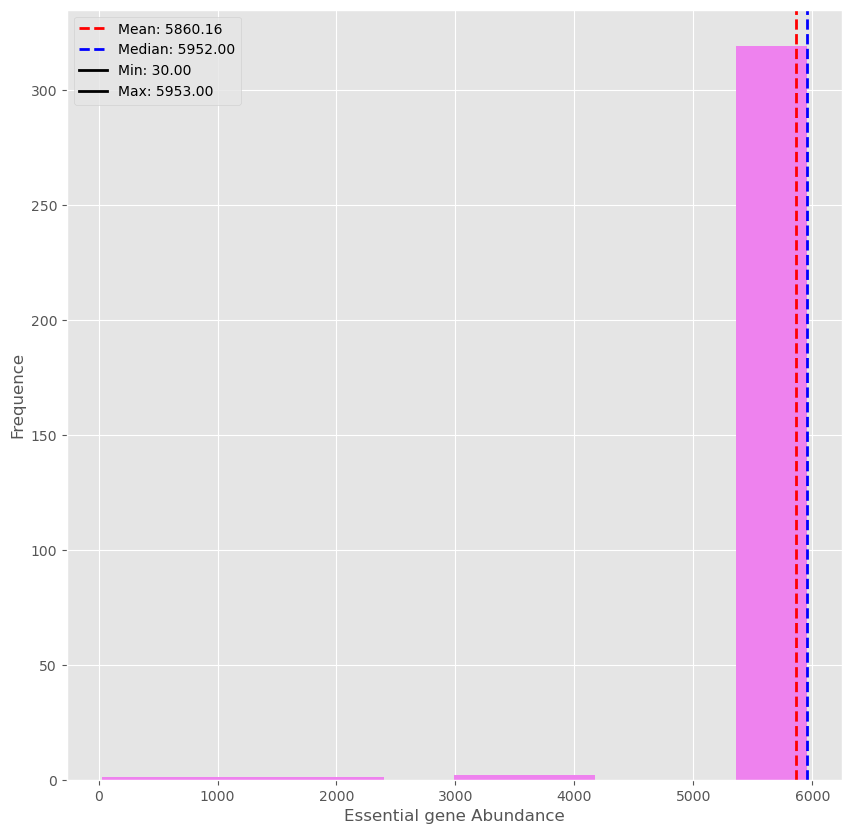

In [69]:
plt.figure(figsize=(10, 10))
plt.hist(gene_sums, color='violet')
plt.xlabel('Essential gene Abundance')
plt.ylabel('Frequence')
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='b', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')
dummy_min = plt.Line2D([], [], color='black',  linewidth=2, label=f'Min: {min_value:.2f}')
dummy_max = plt.Line2D([], [], color='black', linewidth=2, label=f'Max: {max_value:.2f}')

handles = [plt.Line2D([], [], color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}'),
        plt.Line2D([], [], color='b', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}'),
        dummy_min, dummy_max]
plt.legend(handles=handles)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_frequency.pdf", format="pdf", bbox_inches="tight")

In [70]:
print(f"Minimal gene abundance: {gene_sums.min()}")

Minimal gene abundance: 30


# 4) Training of full dataset (train_full_dataset.py script on the CS account)

## 4.1) Full dataset (base model and enhanced model)

In [71]:
# Load trained model 
input_dim = 55039
hidden_dim = 1024
latent_dim = 32
path_to_model = '/Users/anastasiiashcherbakova/Desktop/2_bigdataset/2_bigdataset/8_final_dataset_new_params/saved_KL_annealing_VAE_BD_100.pt'

model, binary_generated_samples = load_model(input_dim, hidden_dim, latent_dim, path_to_model)

Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[5.35712987e-02 3.55034397e-04 1.10267334e-04 ... 7.12330584e-05
  7.46414516e-05 1.67593607e-04]
 [8.02834926e-04 5.62542584e-04 9.19798936e-07 ... 8.31182933e-06
  9.16988211e-06 7.46715668e-05]
 [7.23476382e-03 1.34775881e-03 5.52775127e-05 ... 3.38703940e-05
  3.61194689e-05 9.61214828e-05]
 ...
 [1.07489703e-02 3.82125415e-10 1.29191857e-11 ... 2.04988204e-09
  2.21334173e-09 5.96223515e-09]
 [6.00629998e-03 2.40856079e-05 3.70266906e-04 ... 3.93881201e-05
  4.42324090e-05 5.45731891e-05]
 [3.42151225e-02 5.83144185e-07 3.18221055e-06 ... 4.16648572e-06
  4.73230648e-06 6.25931307e-06]]


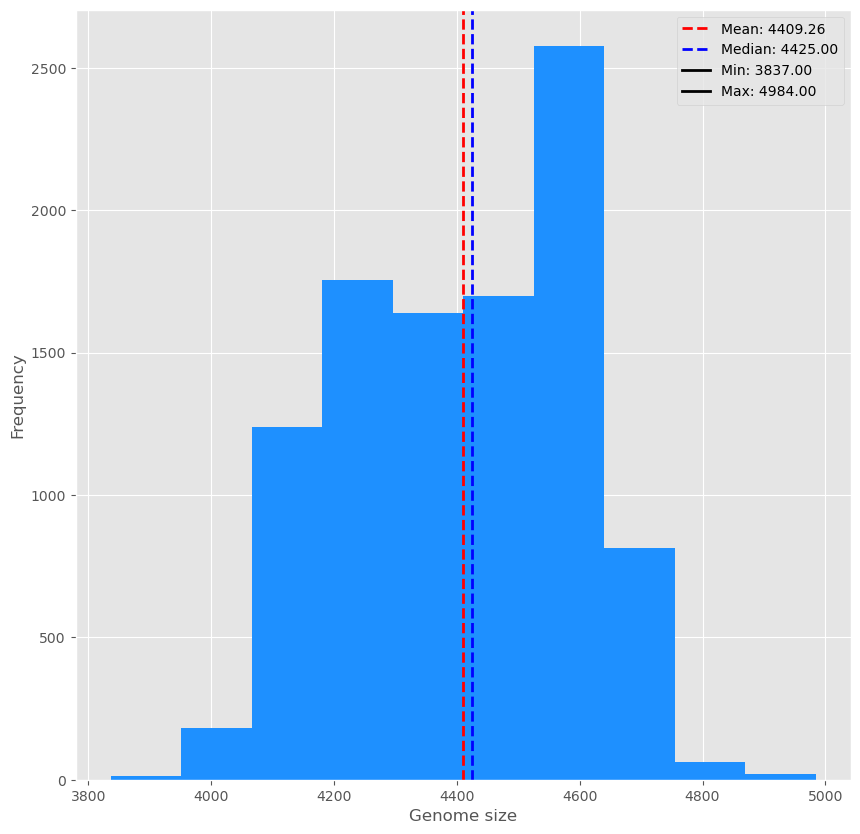

In [72]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_8_final_dataset_new_params.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

In [73]:
binary_generated_samples.sum(axis=1).min()

3837.0

In [74]:
np.mean(binary_generated_samples.sum(axis=1))

4409.262

In [75]:
np.median(binary_generated_samples.sum(axis=1))

4425.0

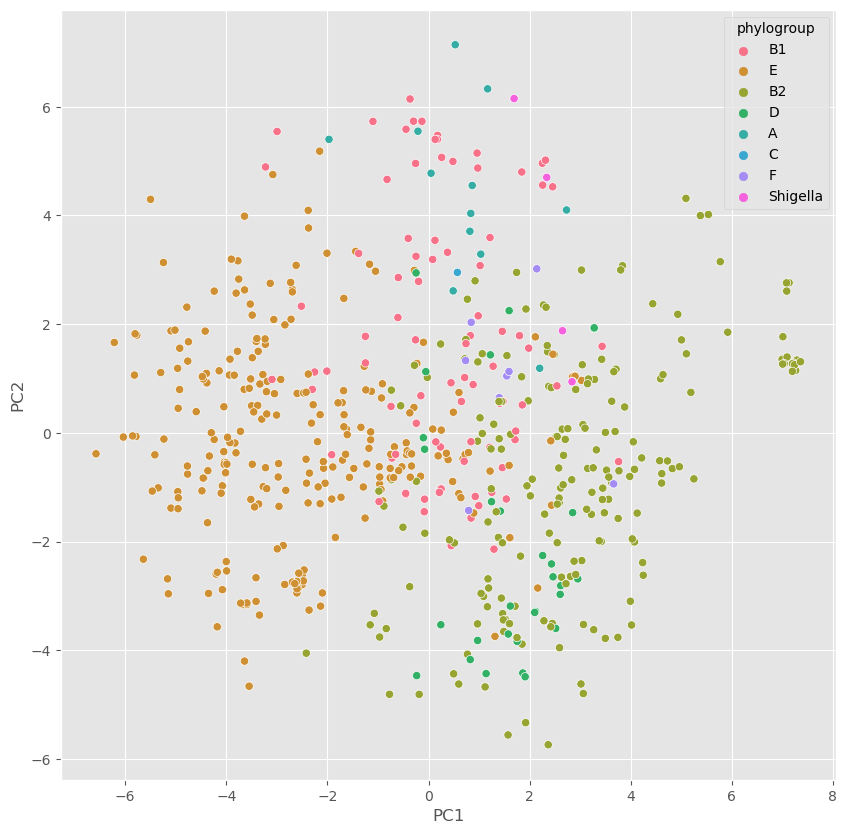

In [76]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/pca_latent_space_visualisation_8_final_dataset_new_params.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [77]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

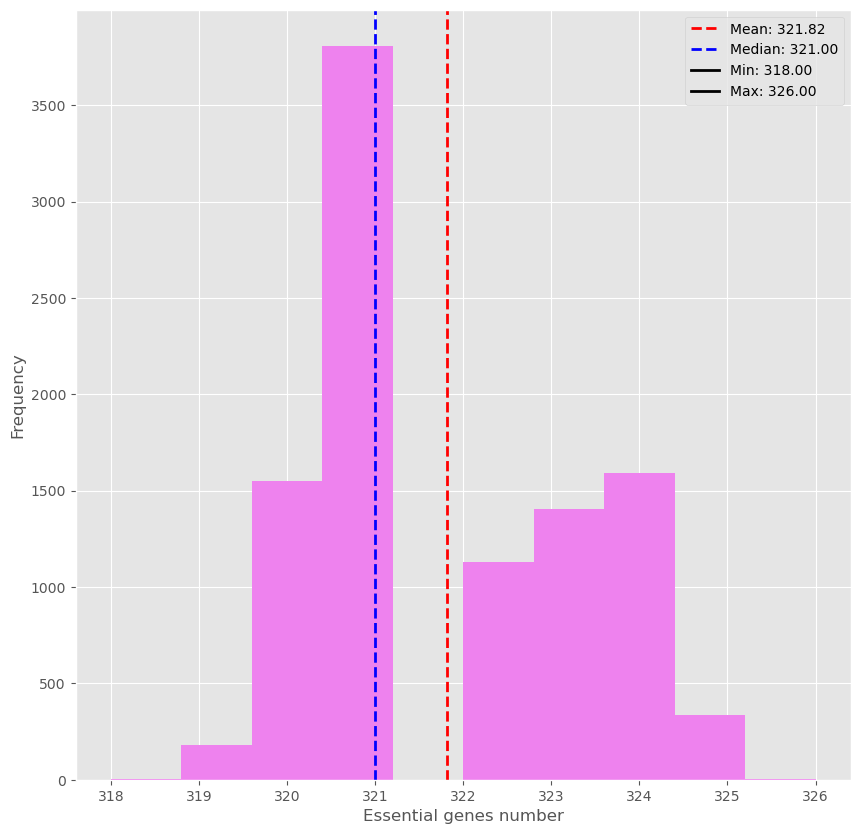

In [78]:
plot_color = "violet"
figure_name ="/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_8_final_dataset_new_params.pdf"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

----------

In [79]:
# Load trained model 
input_dim = 55039
hidden_dim = 1024
latent_dim = 32
path_to_model = "/Users/anastasiiashcherbakova/Desktop/2_bigdataset/2_bigdataset/9_final_dataset_enhanced/saved_KL_annealing_VAE_BD_100.pt"

model, binary_generated_samples = load_model_enhanced(input_dim, hidden_dim, latent_dim, path_to_model)

Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[2.11257371e-04 1.39201068e-08 2.38963640e-08 ... 3.95699224e-08
  4.12448955e-08 3.40340762e-07]
 [2.38181166e-02 1.14669325e-02 8.60406959e-04 ... 3.25852161e-05
  3.81378595e-05 2.23299267e-05]
 [1.32391453e-02 5.04225609e-05 8.78305364e-05 ... 6.16980076e-04
  6.33947202e-04 3.12435266e-04]
 ...
 [3.73905540e-01 7.81974290e-04 4.64289187e-04 ... 7.13872869e-05
  7.57996604e-05 8.30545905e-05]
 [2.95713115e-02 5.32385311e-04 5.39943925e-04 ... 2.24028954e-05
  2.35415246e-05 2.07960748e-05]
 [1.02959888e-03 3.01228518e-08 5.49722984e-07 ... 9.04429726e-07
  1.08680490e-06 2.57387296e-06]]


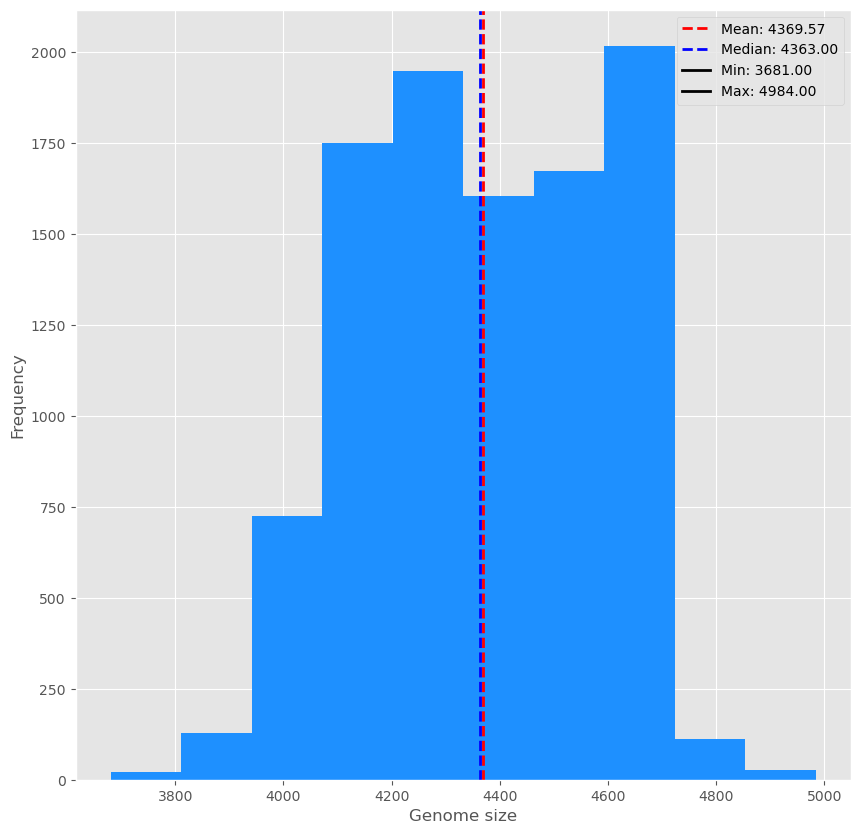

In [80]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_9_final_dataset_enhanced.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

In [81]:
binary_generated_samples.sum(axis=1).min()

3681.0

In [82]:
np.mean(binary_generated_samples.sum(axis=1))

4369.5685

In [83]:
np.median(binary_generated_samples.sum(axis=1))

4363.0

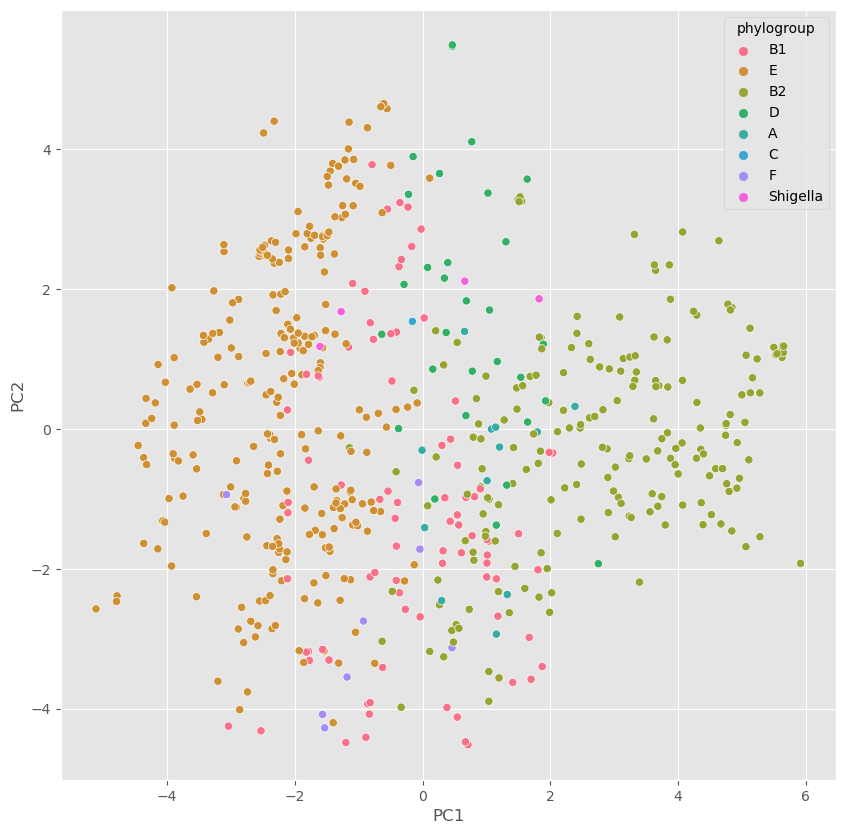

In [84]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/pca_latent_space_visualisation_9_final_dataset_enhanced.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [85]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

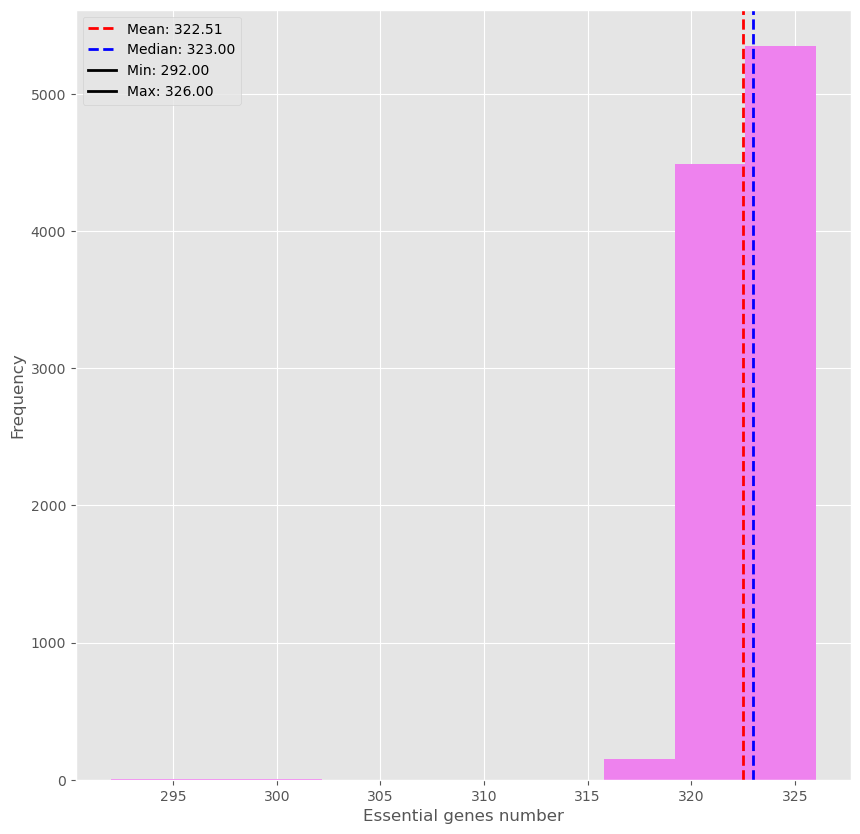

In [86]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_9_final_dataset_enhanced.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

## Exploring ways to minimise genome size

just ran a test model with random initial parameters to see how it woudl perform with a new loss (gene abundance) included. L1 regularisation applied to the fetures in the model. one note: the new loss gama and beta params: 
beta_start = 0.1
beta_end = 1.0
gamma_start = 1.0
gamma_end = 0.1

In [87]:
# Load trained model
input_dim = 55039
hidden_dim = 512
latent_dim = 32
path_to_model = "/Users/anastasiiashcherbakova/git_projects/masters_project/models/saved_8_new_loss_model.pt"

model, binary_generated_samples = load_model(input_dim, hidden_dim, latent_dim, path_to_model)

Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[1.70120737e-04 6.57893179e-05 1.18216985e-05 ... 3.20370309e-05
  3.22363885e-05 7.81204944e-05]
 [7.31373657e-05 1.76035992e-05 3.46085326e-05 ... 1.21119574e-05
  1.12271391e-05 2.44397761e-05]
 [2.71603037e-02 3.90159985e-05 8.51548903e-05 ... 1.01893682e-04
  1.10136505e-04 8.20339992e-05]
 ...
 [4.25404962e-03 4.12504996e-05 4.18501149e-05 ... 6.87264255e-05
  7.07766885e-05 4.65101330e-05]
 [1.41567598e-05 1.92576248e-04 7.69414328e-06 ... 6.27645786e-05
  6.02396685e-05 4.22186167e-05]
 [2.37688720e-02 1.32960745e-03 5.91864635e-04 ... 2.48290416e-05
  2.61056357e-05 2.01474395e-05]]


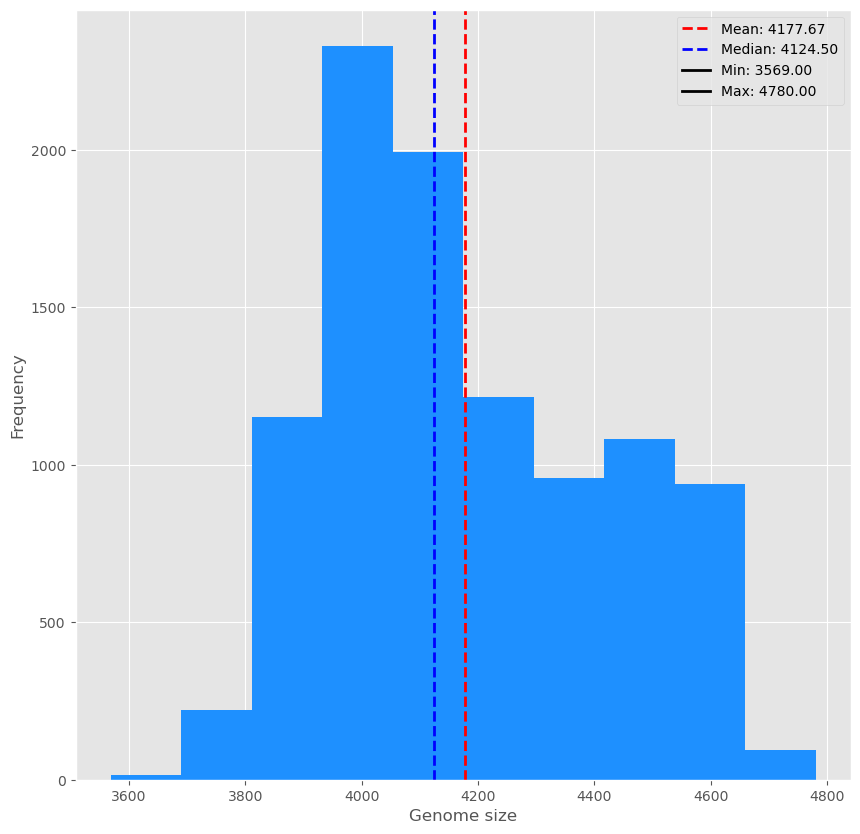

In [88]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_8_new_loss.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

In [89]:
binary_generated_samples.sum(axis=1).min()

3569.0

In [90]:
np.mean(binary_generated_samples.sum(axis=1))

4177.6705

In [91]:
np.median(binary_generated_samples.sum(axis=1))

4124.5

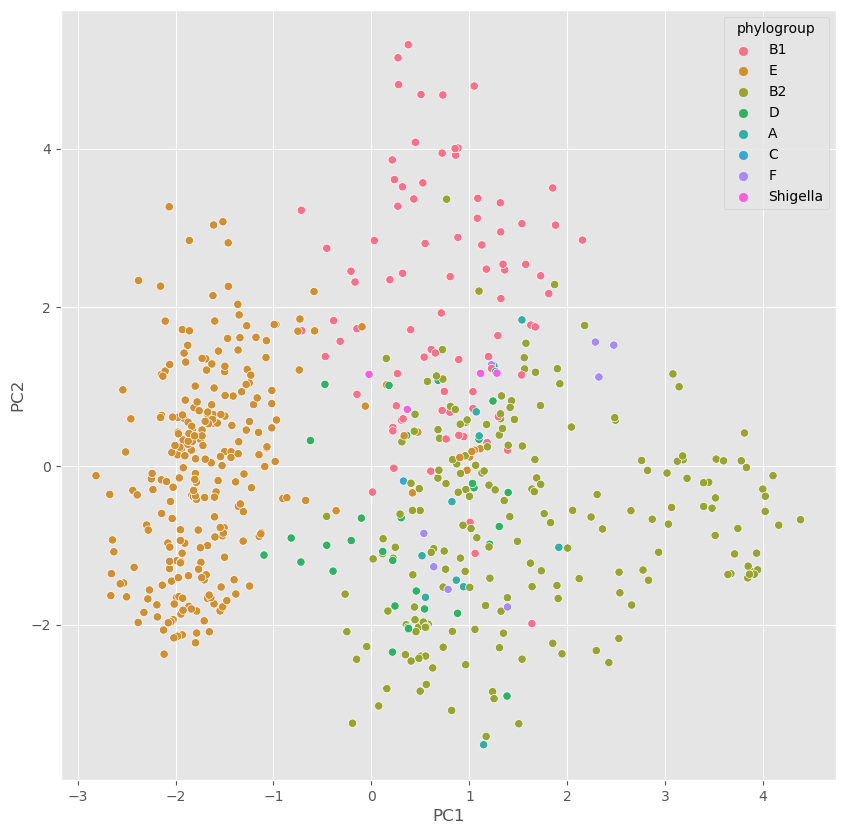

In [92]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/pca_latent_space_visualisation_8_new_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [93]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

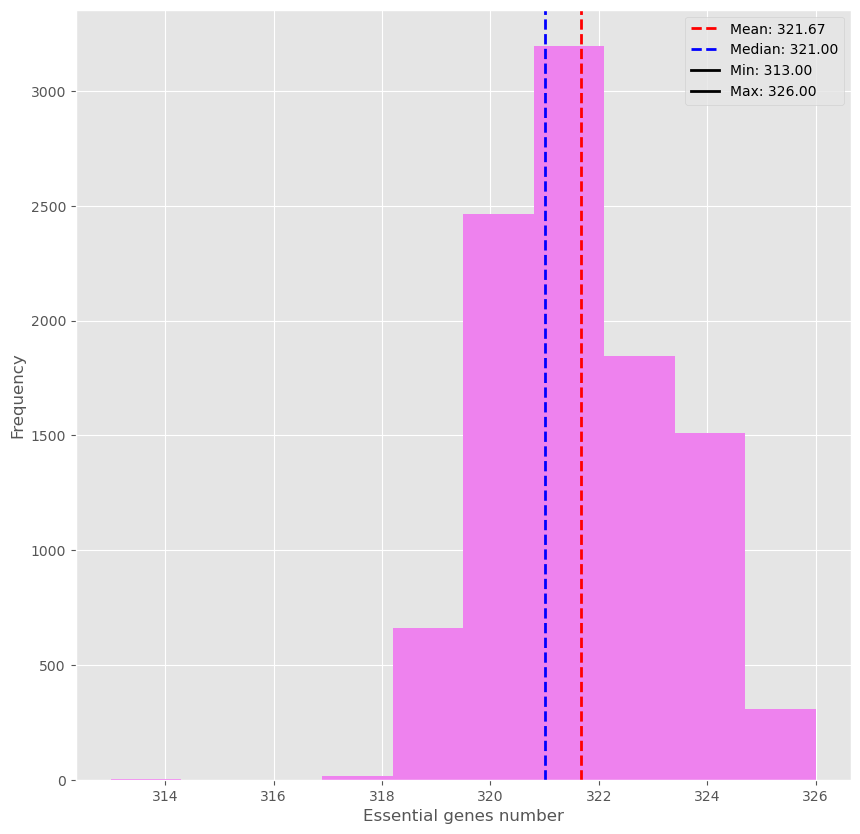

In [94]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_8_new_loss.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

---------

In [95]:
# Load trained model 
input_dim = 55039
hidden_dim = 512
latent_dim = 32

path_to_model = "/Users/anastasiiashcherbakova/git_projects/masters_project/models/saved_8_new_loss_enhanced_model.pt"

model, binary_generated_samples = load_model_enhanced(input_dim, hidden_dim, latent_dim, path_to_model)


Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[7.4898096e-04 7.2083392e-05 7.3051901e-04 ... 3.9702070e-05
  3.9537976e-05 3.4325694e-05]
 [2.5097348e-02 4.2001044e-05 1.3548116e-05 ... 2.3986334e-04
  2.2925172e-04 2.2448099e-04]
 [6.1482089e-03 5.1104053e-05 1.4633330e-04 ... 1.9283063e-05
  1.8895069e-05 1.9103723e-05]
 ...
 [9.8933324e-02 3.4736495e-05 9.6508695e-05 ... 7.0399663e-05
  7.2121758e-05 7.3346411e-05]
 [3.9559967e-05 3.6146031e-03 1.4148443e-03 ... 9.3104281e-05
  9.0444111e-05 7.6526383e-05]
 [7.6781982e-04 1.3455300e-04 8.3263476e-05 ... 3.0501358e-05
  2.9381950e-05 3.3044475e-05]]


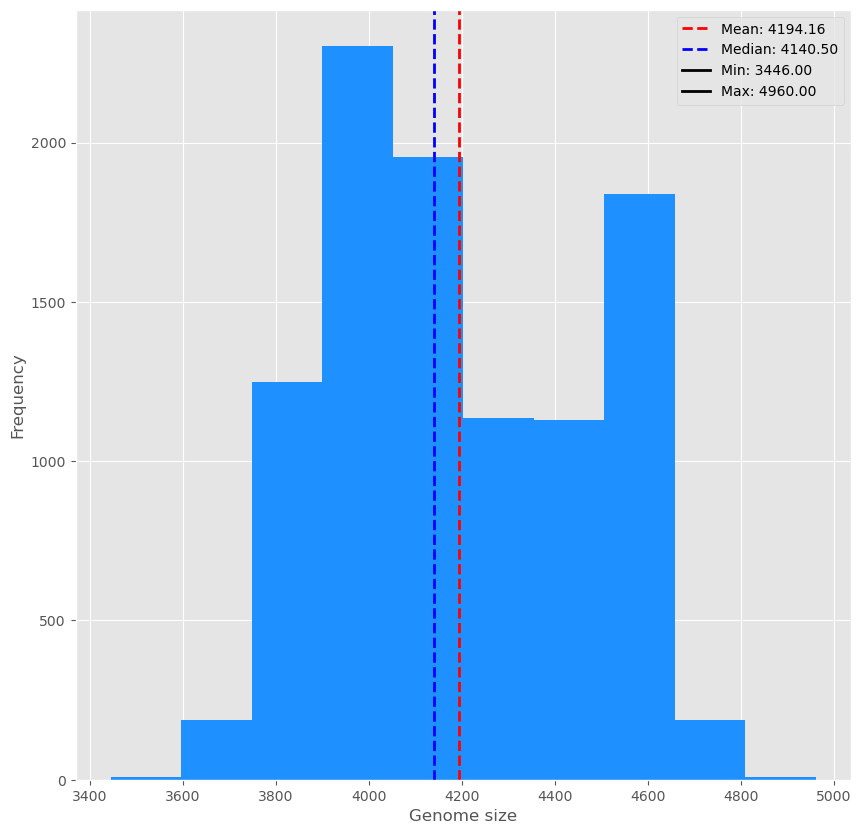

In [96]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_8_new_loss_enhanced_model.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

In [97]:
binary_generated_samples.sum(axis=1).min()

3446.0

In [98]:
np.mean(binary_generated_samples.sum(axis=1))

4194.1569

In [99]:
np.median(binary_generated_samples.sum(axis=1))

4140.5

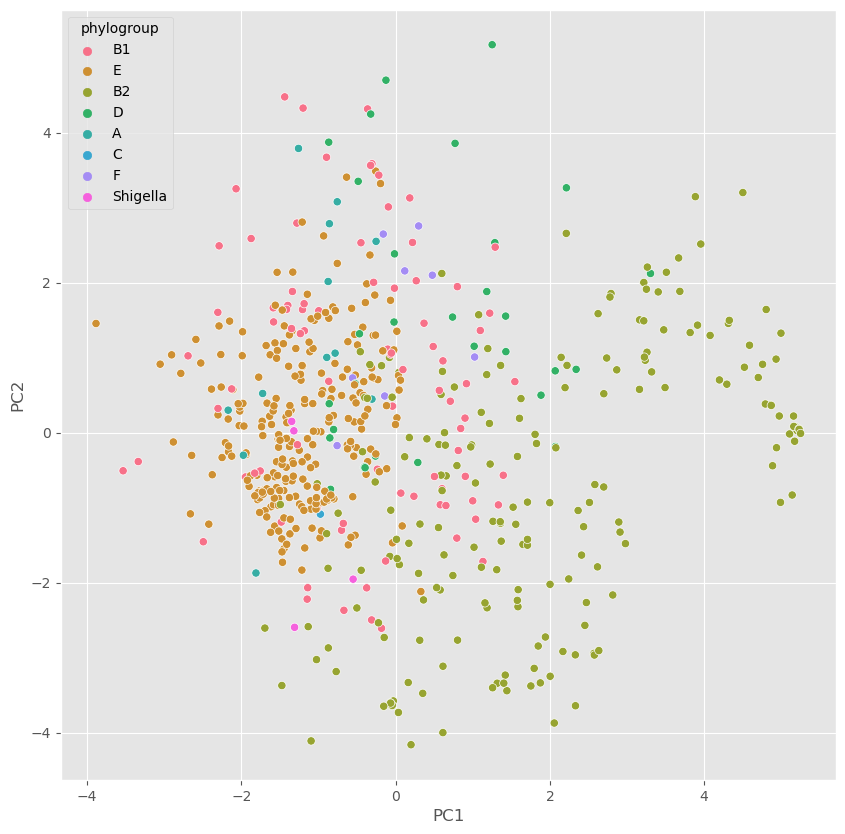

In [100]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/pca_latent_space_visualisation_8_new_loss_enhanced_model.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [101]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

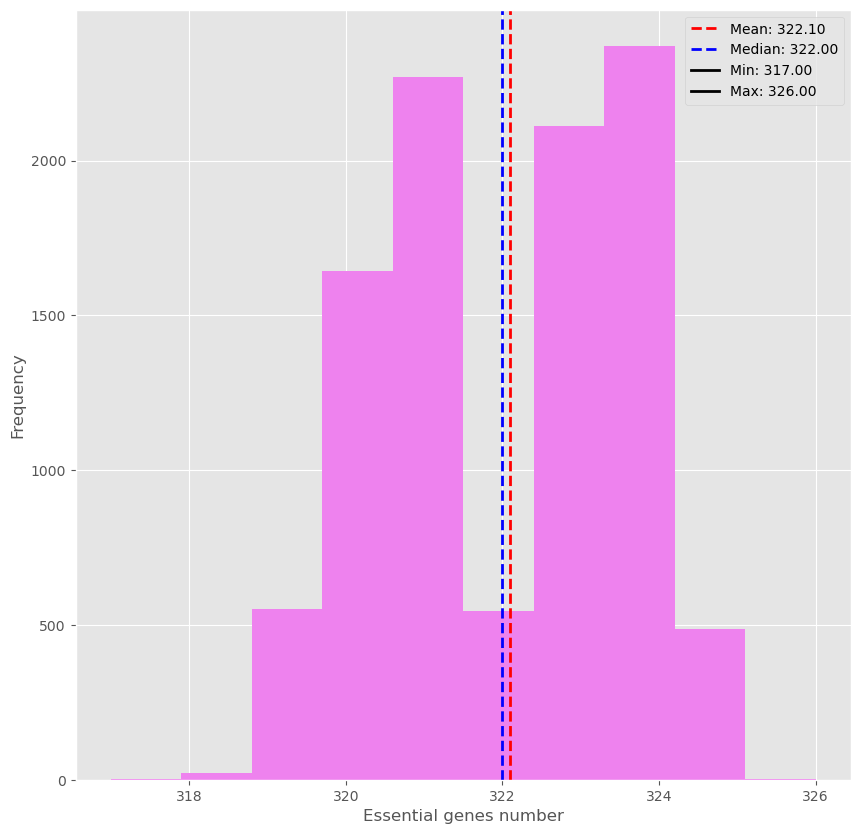

In [102]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_8_new_loss_enhanced_model.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

------

In [103]:
# Load trained model 
input_dim = 55039
hidden_dim = 512
latent_dim = 32

path_to_model = "/Users/anastasiiashcherbakova/git_projects/masters_project/models/saved_11_non_linear_annealing_model.pt"

model, binary_generated_samples = load_model(input_dim, hidden_dim, latent_dim, path_to_model)


Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[8.3763810e-04 4.3659838e-04 1.4337967e-07 ... 4.4180386e-05
  4.7816520e-05 2.6941385e-05]
 [2.1559156e-03 1.2634778e-04 1.7187069e-03 ... 7.4307165e-05
  7.3073577e-05 1.1615292e-04]
 [1.5315543e-05 7.5941032e-05 2.8454102e-04 ... 5.4951961e-05
  5.0939692e-05 3.7126683e-05]
 ...
 [6.6460756e-04 5.1366231e-05 4.0879192e-07 ... 2.7050748e-05
  2.7299719e-05 2.2151573e-05]
 [4.7833167e-04 1.6825381e-03 2.4530338e-03 ... 3.6996338e-05
  3.8857670e-05 5.9258196e-05]
 [1.0931706e-03 1.4607720e-04 1.7242630e-03 ... 1.1595537e-05
  1.2179324e-05 1.6788772e-05]]


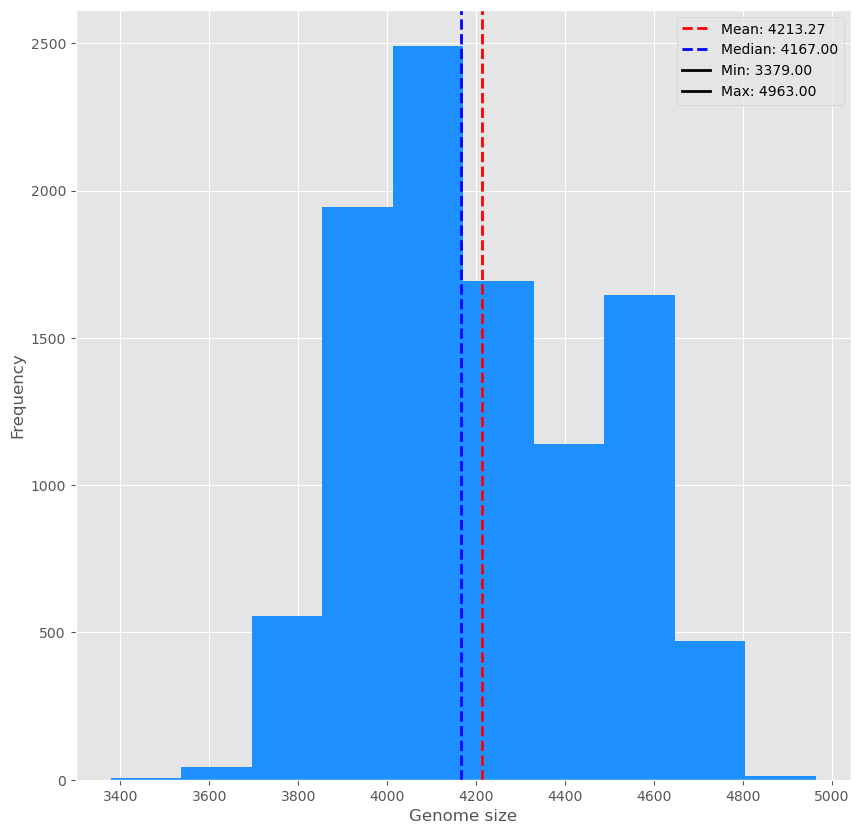

In [104]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_11_non_linear_annealing.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

In [105]:
binary_generated_samples.sum(axis=1).min()

3379.0

In [106]:
np.mean(binary_generated_samples.sum(axis=1))

4213.2698

In [107]:
np.median(binary_generated_samples.sum(axis=1))

4167.0

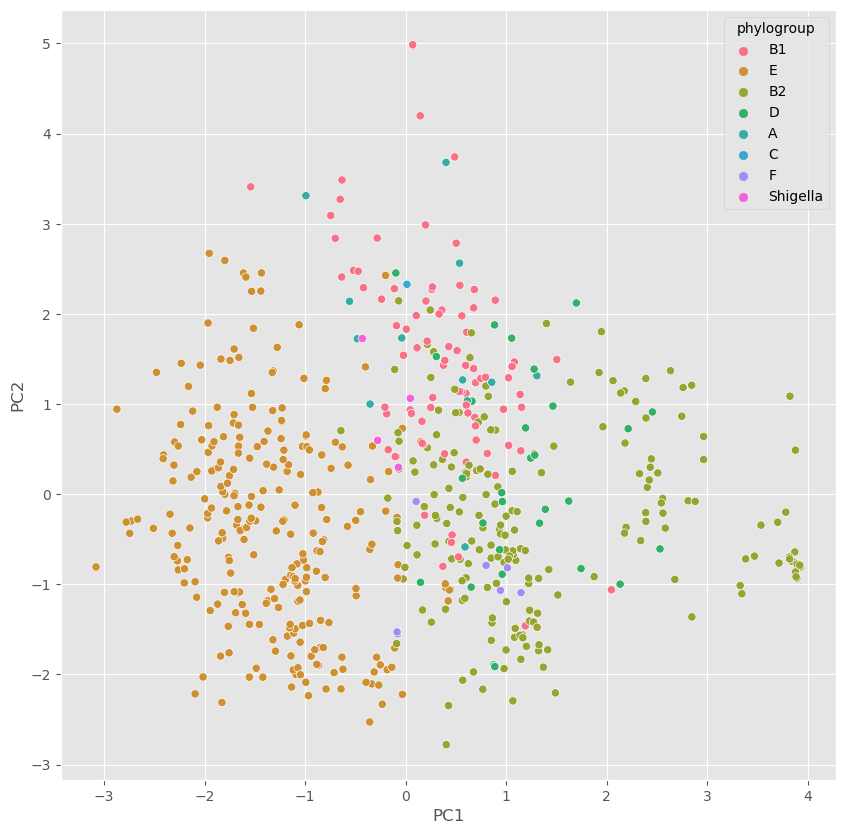

In [108]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/pca_latent_space_visualisation_11_non_linear_annealing.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [109]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

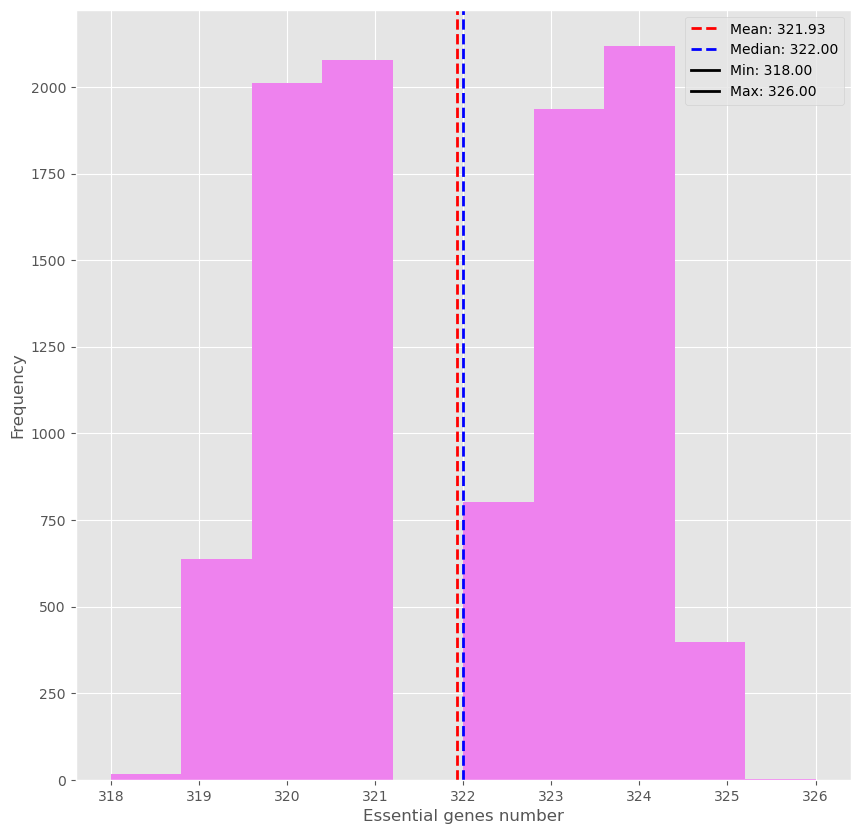

In [110]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_11_non_linear_annealing.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

_______

In [111]:
# Load trained model 
input_dim = 55039
hidden_dim = 512
latent_dim = 32

path_to_model = "/Users/anastasiiashcherbakova/git_projects/masters_project/models/saved_13_add_genome_size_model.pt"

model, binary_generated_samples = load_model(input_dim, hidden_dim, latent_dim, path_to_model)


Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[1.2052672e-01 1.2380024e-04 3.9312526e-04 ... 2.6113752e-04
  2.6051284e-04 1.6159263e-04]
 [7.7132150e-03 5.5012398e-04 1.8338240e-05 ... 1.4802906e-05
  1.4385522e-05 2.3094855e-05]
 [5.9276308e-06 4.4975040e-04 3.6528595e-06 ... 5.0961509e-05
  5.2279436e-05 4.2895583e-05]
 ...
 [6.8280315e-05 3.8391543e-05 6.7315646e-05 ... 1.6352441e-04
  1.7535656e-04 1.1302983e-04]
 [4.0705130e-03 7.9476968e-06 1.2524003e-04 ... 6.7530664e-06
  6.5613158e-06 1.1598158e-05]
 [2.1072365e-04 3.1358955e-04 5.4561428e-06 ... 6.3891865e-05
  6.6537919e-05 3.2358788e-05]]


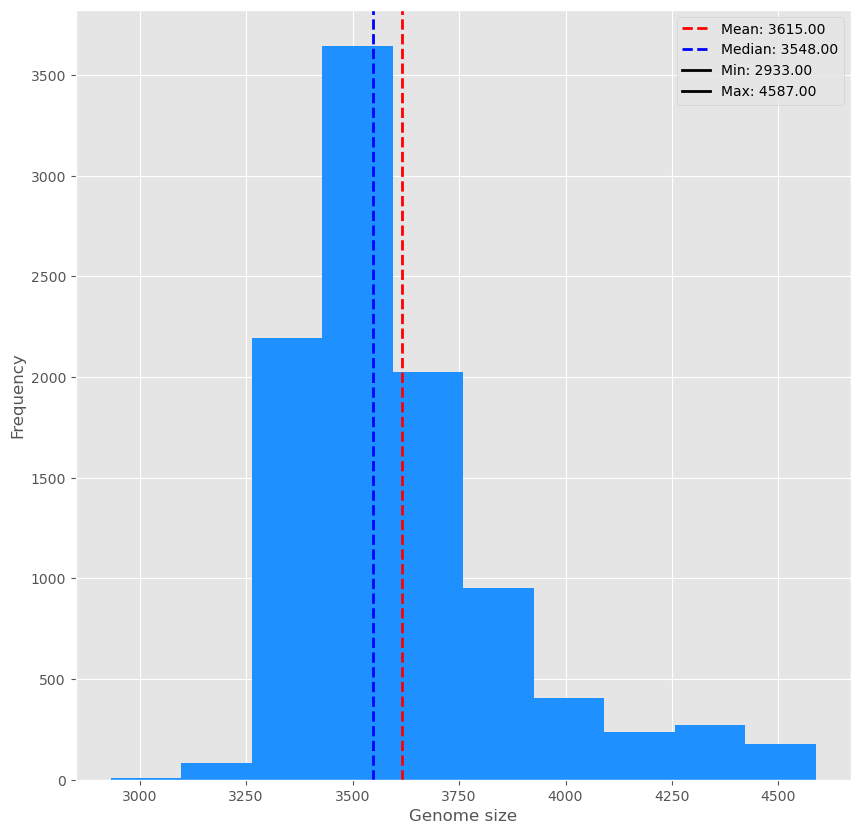

In [112]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_13_add_genome_size.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

In [113]:
binary_generated_samples.sum(axis=1).min()

2933.0

In [114]:
np.mean(binary_generated_samples.sum(axis=1))

3614.9956

In [115]:
np.median(binary_generated_samples.sum(axis=1))

3548.0

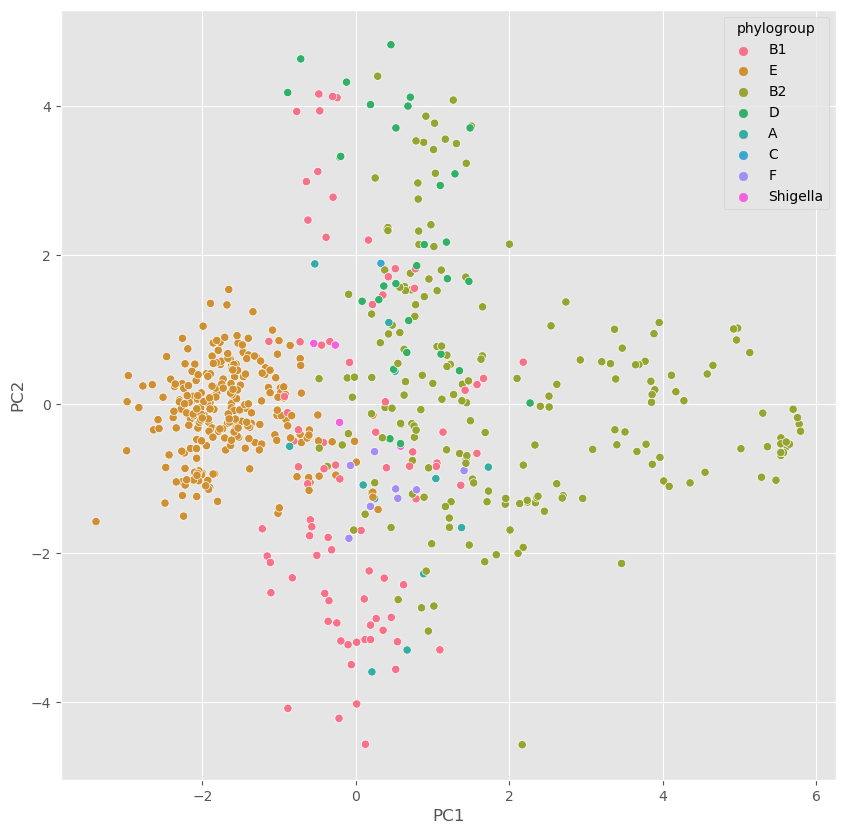

In [116]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/pca_latent_space_visualisation_13_add_genome_size_model.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [117]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

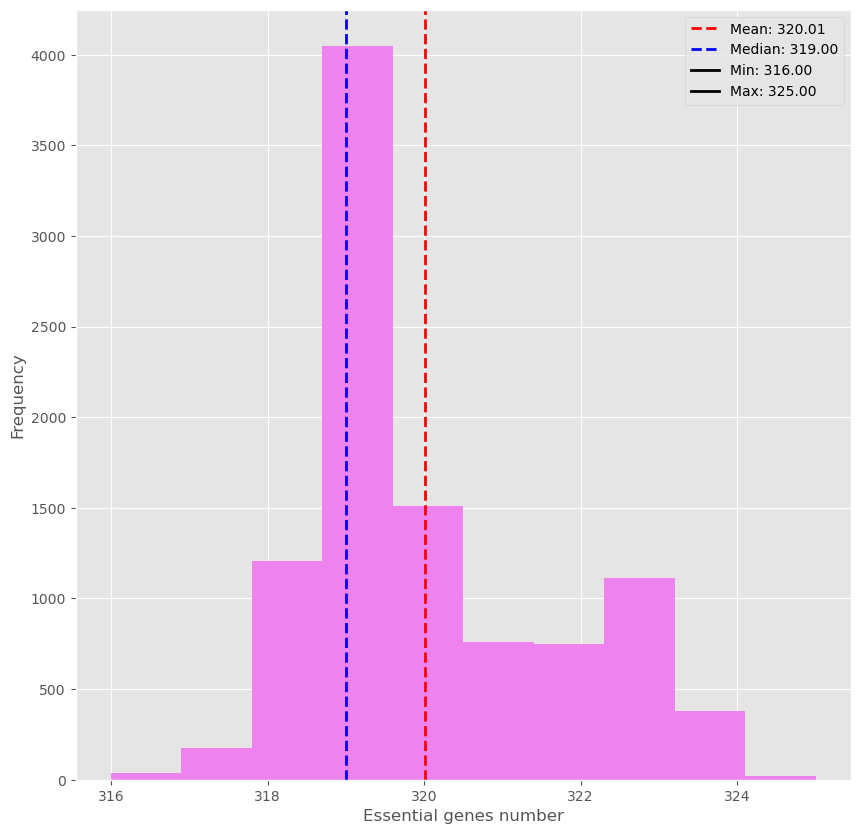

In [118]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_13_add_genome_size.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

______

In [119]:
# Load trained model 
input_dim = 55039
hidden_dim = 512
latent_dim = 32

path_to_model = "/Users/anastasiiashcherbakova/git_projects/masters_project/models/saved_15_genome_size_and_cyclic_annealing_SCALED_model.pt"

model, binary_generated_samples = load_model(input_dim, hidden_dim, latent_dim, path_to_model)


Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[9.4782177e-04 2.4178005e-05 3.8729777e-05 ... 2.1445234e-05
  2.0522499e-05 2.8139242e-05]
 [1.2190142e-02 8.3441219e-06 2.0195836e-04 ... 2.1957216e-05
  2.1325317e-05 2.6980208e-05]
 [1.1531855e-03 3.5193682e-04 5.5727346e-06 ... 6.2433806e-05
  6.1657891e-05 6.5599619e-05]
 ...
 [1.5891645e-04 2.2288828e-04 2.9998546e-06 ... 1.0532105e-04
  1.0073609e-04 1.0980429e-04]
 [1.8942663e-05 9.0220547e-06 1.0786447e-04 ... 9.1415404e-06
  8.9768764e-06 1.2912629e-05]
 [5.9075272e-05 1.3959210e-03 3.6669775e-07 ... 4.8544203e-05
  4.7330548e-05 3.3417913e-05]]


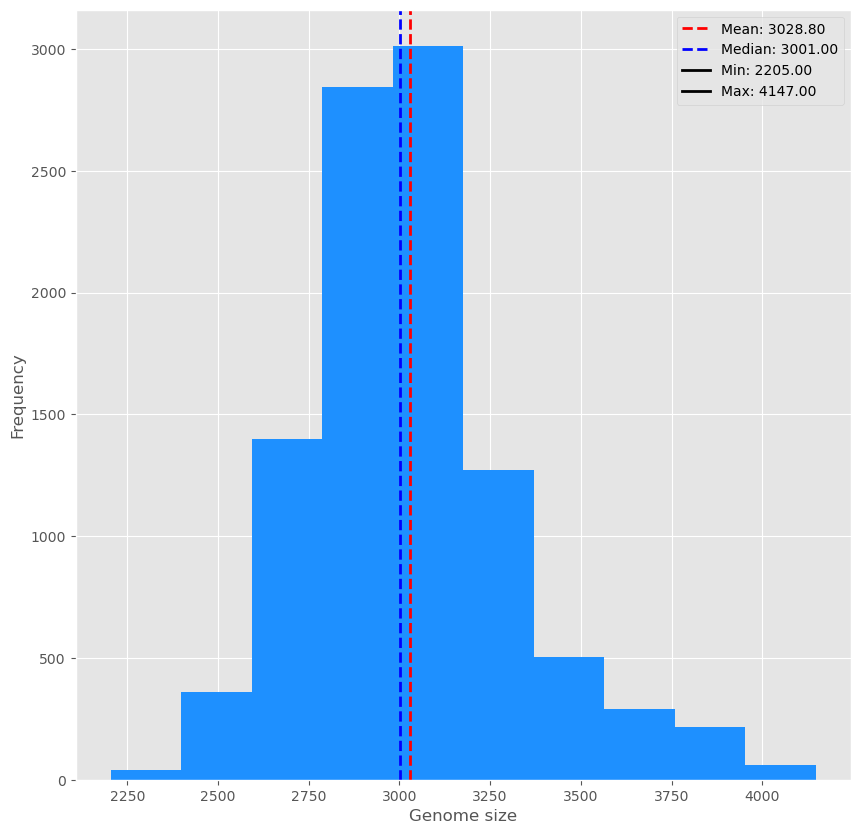

In [120]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_15_genome_size_and_cyclic_annealing_SCALED.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

In [121]:
binary_generated_samples.sum(axis=1).min()

2205.0

In [122]:
np.mean(binary_generated_samples.sum(axis=1))

3028.7958

In [123]:
np.median(binary_generated_samples.sum(axis=1))

3001.0

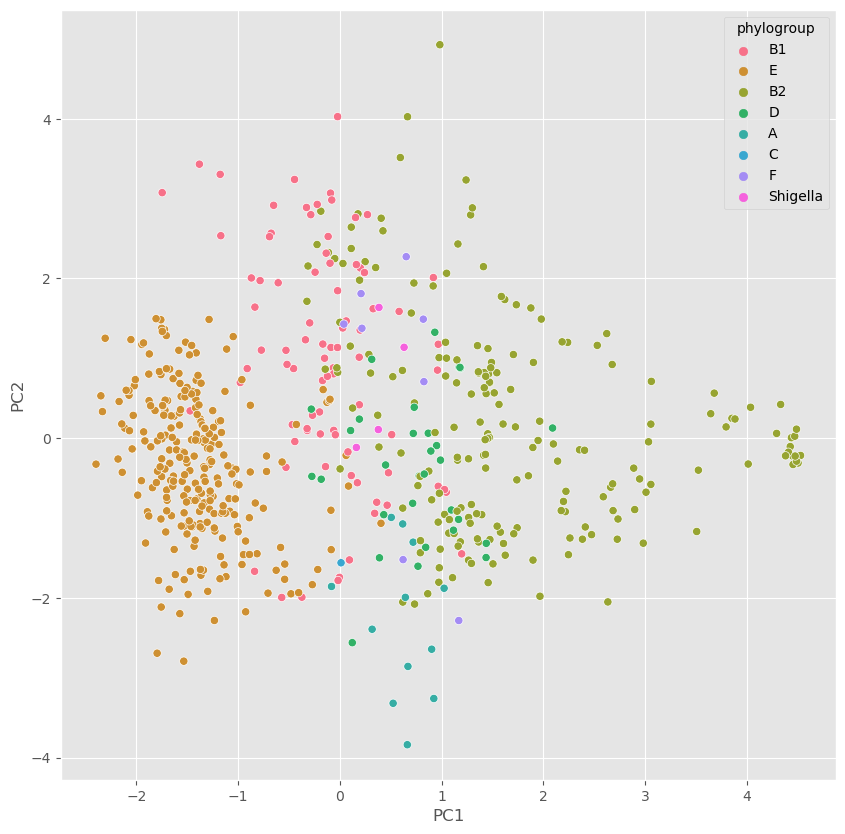

In [124]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/pca_latent_space_visualisation_15_genome_size_and_cyclic_annealing_SCALED.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [125]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

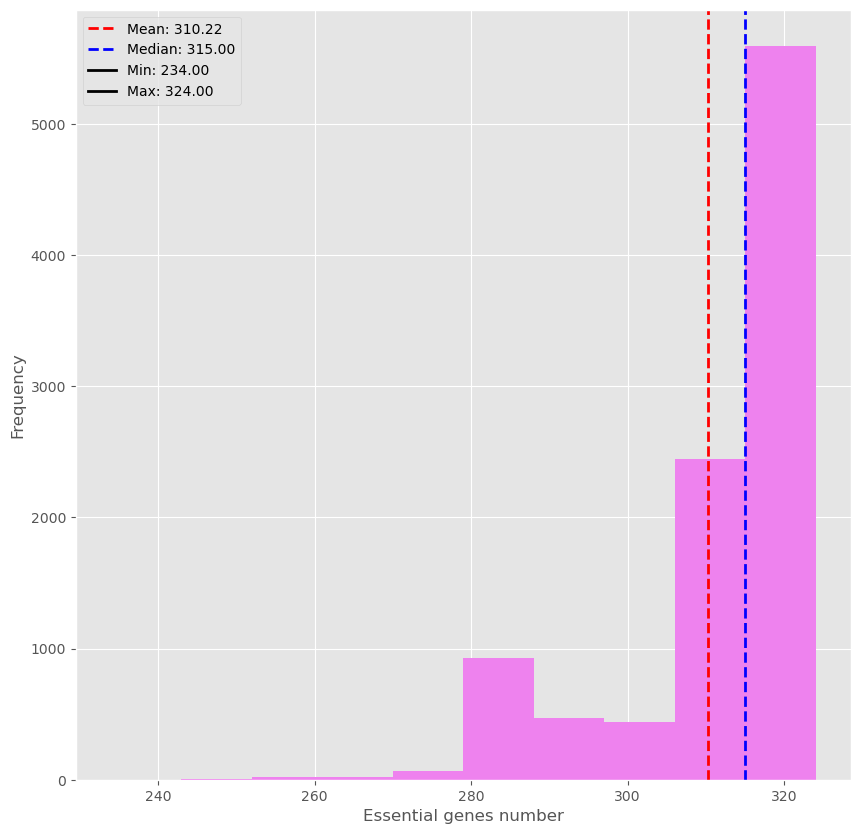

In [126]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_15_genome_size_and_cyclic_annealing_SCALED.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

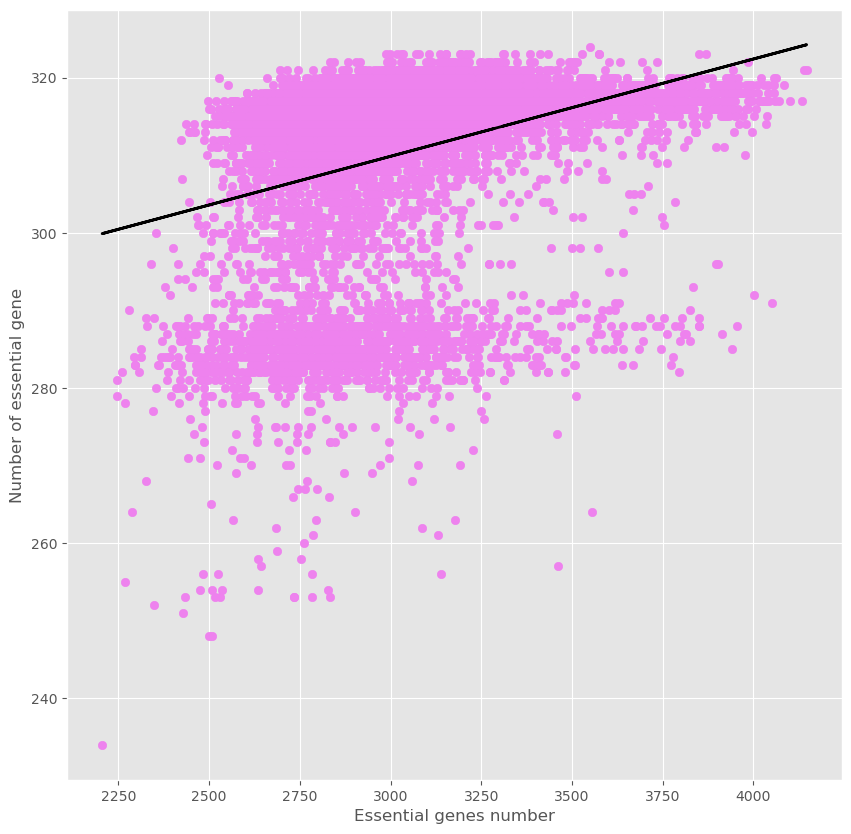

In [127]:
plt.figure(figsize=(10,10))
plt.scatter(binary_generated_samples.sum(axis=1), essential_genes_count_per_sample, color='violet')

coefficients = np.polyfit(binary_generated_samples.sum(axis=1), essential_genes_count_per_sample, 1)
trendline = np.poly1d(coefficients)

plt.plot(binary_generated_samples.sum(axis=1), trendline(binary_generated_samples.sum(axis=1)), color='black', linewidth=2)

plt.xlabel('Essential genes number') 
plt.ylabel('Number of essential gene')

plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/GS_EG_15_genome_size_and_cyclic_annealing_SCALED.pdf", format="pdf", bbox_inches="tight")

In [128]:
# Generate 10 new samples
num_samples = 10000
with torch.no_grad():
    z = torch.randn(num_samples, latent_dim)  # Sample from the standard normal distribution because the latent space follows normal distribution 
    generated_samples = model.decode(z).cpu().numpy() 

threshold = 0.5
binary_generated_samples = (generated_samples > threshold).astype(float)

print("Generated samples (binary):\n", binary_generated_samples)
print("\n")
print("Generated samples (sigmoid function output):\n", generated_samples)


Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[5.6426952e-06 2.2634996e-04 7.2002622e-06 ... 1.9320651e-05
  1.8155633e-05 3.9613686e-05]
 [7.7384837e-05 1.8103954e-05 5.4598389e-05 ... 5.0422850e-06
  5.0564809e-06 2.7030042e-06]
 [2.3758862e-02 2.4724652e-05 2.4761461e-05 ... 5.5624711e-05
  5.4577304e-05 7.1879804e-05]
 ...
 [4.1547562e-03 3.4022437e-06 3.5199837e-06 ... 2.3773539e-06
  2.3117734e-06 1.6849200e-06]
 [1.8163411e-04 4.5746452e-05 2.6613707e-03 ... 2.8442545e-04
  2.8137551e-04 2.8699471e-04]
 [1.3379610e-04 4.0456327e-04 1.5301818e-03 ... 3.2779888e-05
  3.2788797e-05 7.3643641e-05]]


In [129]:
total_ones = np.sum(binary_generated_samples, axis=1)
min_ones_index = np.argmin(total_ones)

latent_distances = np.linalg.norm(generated_samples - generated_samples[min_ones_index], axis=1)

closest_latent_index = np.argmin(latent_distances)

print(f"Closest latent vector (z): {z[closest_latent_index]}")
print(f"Generated sample from closest latent vector:\n {generated_samples[closest_latent_index]}")

Closest latent vector (z): tensor([ 0.6858,  2.9236,  0.6634,  1.2381, -0.2638, -0.3132, -0.9335, -0.4519,
        -0.9354,  0.3815, -0.0298,  0.0410, -0.4877, -0.0219, -0.9559, -1.5276,
         1.1121,  0.1477,  0.2831, -0.2590,  1.8236, -1.8486, -0.7828, -0.5236,
         0.7887,  0.8619, -0.3614,  0.6999, -0.3983, -0.3974, -0.4470,  0.9002])
Generated sample from closest latent vector:
 [2.7018341e-05 8.4325162e-05 1.8047864e-04 ... 3.5848953e-03 3.6224807e-03
 3.6377960e-03]


In [130]:
sum(binary_generated_samples[min_ones_index])

2239.0

In [131]:
latent_distances

array([11.816039, 18.734877, 11.772964, ..., 18.569347, 10.928969,
       11.838083], dtype=float32)

In [132]:
z_of_interest = z[closest_latent_index] 
z_of_interest_tensor = torch.tensor(z_of_interest).unsqueeze(0)  

noise_std = 0.1

num_additional_samples = 10000  
with torch.no_grad():
    noise = torch.randn(num_additional_samples, latent_dim) * noise_std
    z_samples = z_of_interest_tensor + noise
    additional_generated_samples = model.decode(z_samples).cpu().numpy()


print("Additional generated samples:")
print(additional_generated_samples)

/var/folders/nx/hnfjrvz145n2_hzn95z65pmc0000gn/T/ipykernel_99109/2647228576.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_of_interest_tensor = torch.tensor(z_of_interest).unsqueeze(0)


Additional generated samples:
[[4.3384898e-05 1.1404503e-04 2.3003557e-04 ... 2.3839751e-03
  2.4240008e-03 2.4806280e-03]
 [1.5595926e-05 5.9412330e-05 1.5867584e-04 ... 3.4439706e-03
  3.4963125e-03 3.4435436e-03]
 [1.3878486e-05 9.4397248e-05 1.6207223e-04 ... 6.5053296e-03
  6.6695693e-03 6.2020649e-03]
 ...
 [2.9979361e-05 6.2466264e-05 2.1262525e-04 ... 2.4361683e-03
  2.4778540e-03 2.3093501e-03]
 [1.6629299e-05 9.2203794e-05 2.4229544e-04 ... 4.9288748e-03
  4.9998574e-03 5.1560118e-03]
 [1.7509670e-05 8.0175116e-05 1.4300901e-04 ... 4.4412375e-03
  4.4759079e-03 4.4286977e-03]]


In [133]:
threshold = 0.5
additional_generated_samples = (additional_generated_samples > threshold).astype(float)

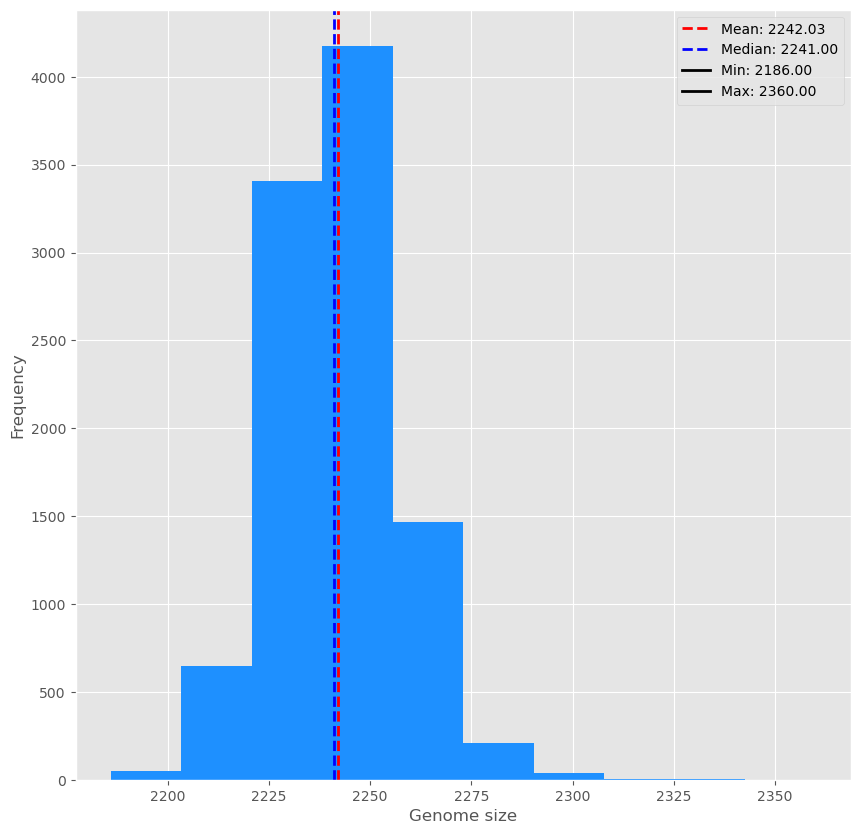

In [134]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/additional_sampling_10000_genome_size_distribution_15_genome_size_and_cyclic_annealing_SCALED.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(additional_generated_samples, figure_name, plot_color)


In [135]:
essential_gene_positions

{'rpsT': [15341],
 'ribF': [15340],
 'ileS': [15339],
 'lspA': [15338, 36962, 42383],
 'ispH': [15336],
 'dapB': [15334, 40591],
 'folA': [1511, 15316],
 'lptD': [15308],
 'ftsL': [15283],
 'ftsI': [15282, 40806],
 'murE': [15281, 40807],
 'murF': [15280, 33264, 33265, 40809],
 'mraY': [15279, 40810],
 'murD': [15278, 33262, 33263],
 'ftsW': [15277],
 'murG': [15276],
 'murC': [15275],
 'ftsQ': [15273],
 'ftsA': [15272],
 'ftsZ': [15271],
 'lpxC': [15270],
 'secA': [15268],
 'coaE': [11933],
 'aceF': [11944],
 'lpd': [19570],
 'can': [11956],
 'hemL': [11985, 42003],
 'erpA': [11987, 37359],
 'dapD': [11996],
 'map': [11998, 39912],
 'rpsB': [11999],
 'tsf': [12000, 48412],
 'pyrH': [12001],
 'frr': [12002],
 'dxr': [12003],
 'cdsA': [12006, 12100, 29339, 30377, 34707],
 'bamA': [12008],
 'lpxD': [12010, 46997],
 'fabZ': [12011],
 'lpxA': [12012],
 'lpxB': [12013],
 'dnaE': [9123, 12015, 18059, 23498, 31303, 41020, 50504],
 'accA': [12016, 40738],
 'tilS': [12019, 40737],
 'proS': [164

In [136]:
additional_generated_samples.sum(axis=1)

array([2248., 2246., 2241., ..., 2242., 2252., 2228.])

In [137]:
additional_generated_samples

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [138]:
essential_genes_count_per_sample = count_essential_genes(additional_generated_samples, essential_gene_positions)

In [139]:
essential_genes_count_per_sample

array([282, 283, 282, ..., 283, 283, 283])

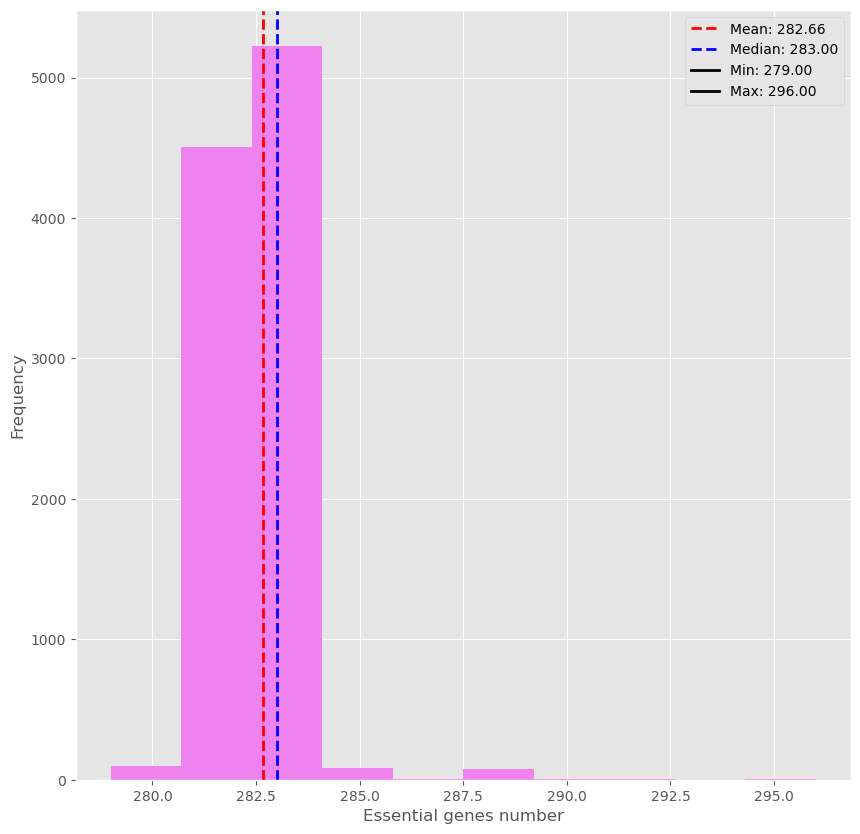

In [140]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/additioinal_essential_genes_15_genome_size_and_cyclic_annealing_SCALED.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

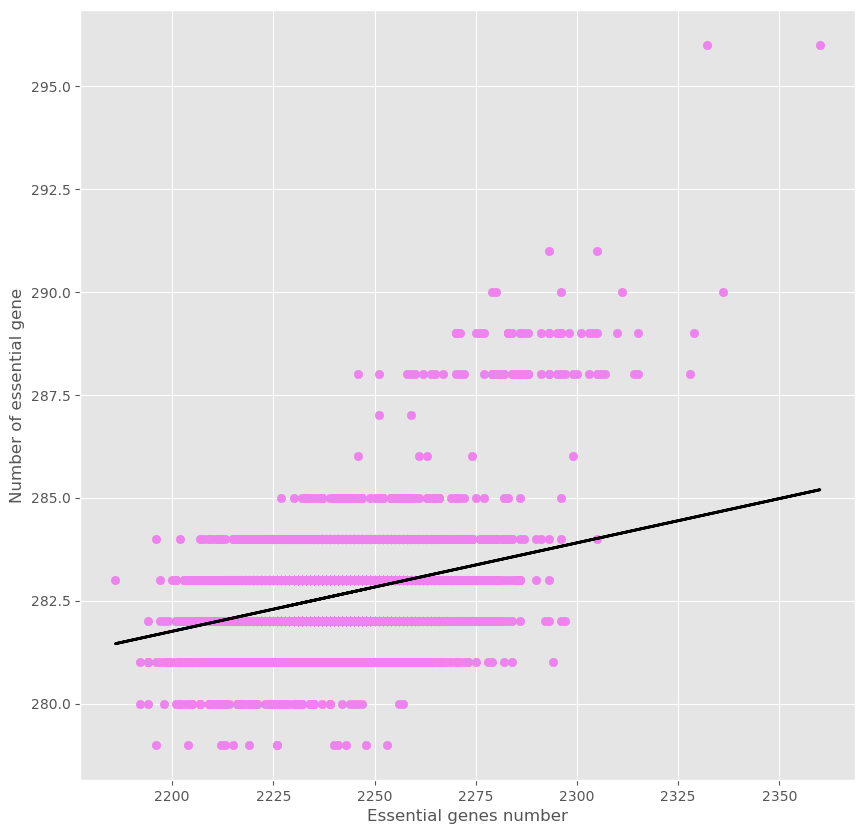

In [141]:
plt.figure(figsize=(10,10))
plt.scatter(additional_generated_samples.sum(axis=1), essential_genes_count_per_sample, color='violet')

coefficients = np.polyfit(additional_generated_samples.sum(axis=1), essential_genes_count_per_sample, 1)
trendline = np.poly1d(coefficients)

plt.plot(additional_generated_samples.sum(axis=1), trendline(additional_generated_samples.sum(axis=1)), color='black', linewidth=2)

plt.xlabel('Essential genes number') 
plt.ylabel('Number of essential gene')

plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/additional_GS_EG_15_genome_size_and_cyclic_annealing_SCALED.pdf", format="pdf", bbox_inches="tight")

---------

In [142]:
def extract_prefix(gene):
    match = re.match(r"([a-zA-Z0-9]+)", gene)
    if match:
        return match.group(1)
    return gene

# Step 1: Get the top 100 essential gene counts
top_100_values = np.sort(essential_genes_count_per_sample)[-100:][::-1]

# Step 2: Find the sequence indices in the array
sequence_indices = []
for value in top_100_values:
    indices = np.where(essential_genes_count_per_sample == value)[0]
    sequence_indices.extend(indices)

# Ensure we only get the first 100 unique indices in case of duplicates
sequence_indices = sequence_indices[:100]

# Step 3: Get the samples from additional_generated_samples
samples = additional_generated_samples[sequence_indices]

# Step 4: Find what genes they have present
present_genes_lists = []
for sample in samples:
    present_genes = all_genes[:-1][sample == 1]
    present_genes_lists.append(present_genes)

# Step 5: Clean up the gene names and add essential genes
cleaned_genes_lists = []
for genes in present_genes_lists:
    cleaned_gene_names = [extract_prefix(name) for name in genes]
    cleaned_gene_names.extend(datatset_EG) 
    cleaned_genes_lists.append(cleaned_gene_names)

np.save('cleaned_genes_lists.npy', cleaned_genes_lists)

/Users/anastasiiashcherbakova/opt/anaconda3/envs/learning_env/lib/python3.8/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [143]:
top_100_values

array([296, 296, 291, 291, 290, 290, 290, 290, 290, 289, 289, 289, 289,
       289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289,
       289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289,
       289, 289, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 287, 287, 286, 286, 286, 286,
       286, 285, 285, 285, 285, 285, 285, 285, 285])

In [144]:
saved_values = essential_genes_count_per_sample[-100:][::-1]

In [145]:
sequence_indecies = []
for i in saved_values:
    sequence_indecies.append(np.where(essential_genes_count_per_sample == i))

In [146]:
additional_generated_samples[3551]

array([0., 0., 0., ..., 0., 0., 0.])

In [147]:
present_genes = all_genes[:-1][additional_generated_samples[3551] == 1]

In [148]:
present_genes

Index(['group_2908', 'group_10126_1', 'group_32', 'group_4411', 'yigB',
       'pstS1', 'emrA', 'fbaA_2', 'evgS_2', 'upp',
       ...
       'group_3194_5', 'epsL', 'gspK', 'glcA', 'group_1927_1', 'sppA_2',
       'yjgN_1_1', 'group_11488_2', 'yicJ_2', 'hypBA1'],
      dtype='object', length=2221)

In [149]:
cleaned_gene_names = [extract_prefix(name) for name in present_genes]
cleaned_gene_names_2 = cleaned_gene_names
unique_gene_names = list(set(cleaned_gene_names))
cleaned_gene_names_2 += datatset_EG
unique_gene_names_2 = list(set(cleaned_gene_names_2))

In [150]:
len(unique_gene_names)

1853

In [151]:
len(unique_gene_names_2)

1896

In [152]:
unique_gene_names_2

['queD',
 'atpC',
 'fabA',
 'ylmA',
 'cysE',
 'yccA',
 'pncA',
 'leuO',
 'recR',
 'ilvH',
 'ydhF',
 'lldR',
 'mgsA',
 'fre',
 'yhfA',
 'xseA',
 'dnaB',
 'sbcB',
 'folA',
 'uspB',
 'ubiF',
 'sapC',
 'yidH',
 'occR',
 'nuoM',
 'dtpA',
 'dlsT',
 'fliA',
 'dusC',
 'pepQ',
 'zntA',
 'nikD',
 'ulaD',
 'sstT',
 'yejB',
 'fruA',
 'gntP',
 'ycgR',
 'glpC',
 'mdtA',
 'yedF',
 'yqjE',
 'gnd',
 'ptsI',
 'sapB',
 'cydB',
 'alx',
 'argO',
 'yhdJ',
 'smpB',
 'leuD',
 'argG',
 'atpI',
 'fur',
 'pnuC',
 'sufS',
 'dgcP',
 'ydfO',
 'aceE',
 'flgM',
 'pspF',
 'eutL',
 'hisJ',
 'zapA',
 'wecB',
 'pyrC',
 'rplC',
 'hflD',
 'ubiI',
 'mzrA',
 'fabI',
 'srmB',
 'psuG',
 'purE',
 'crr',
 'exbD',
 'yfdX',
 'rcsF',
 'mipA',
 'acm',
 'ftsZ',
 'eamB',
 'pdeK',
 'ygfA',
 'map',
 'galS',
 'yqhD',
 'uspA',
 'narJ',
 'artM',
 'btuF',
 'ygdG',
 'hslO',
 'rplT',
 'lldD',
 'purK',
 'metK',
 'mlaF',
 'ygiD',
 'pstS1',
 'fimH',
 'fabH',
 'osmB',
 'rsfS',
 'pncC',
 'rnd',
 'ycdX',
 'udk',
 'znuB',
 'glnD',
 'yqeG',
 'rbfA',


In [153]:
np.save('/Users/anastasiiashcherbakova/git_projects/masters_project/data/unique_gene_names.npy', unique_gene_names_2)

---------

In [154]:
import pandas as pd
file_path = '/Users/anastasiiashcherbakova/git_projects/masters_project/data/essential_genes_website.txt'

df = pd.read_csv(file_path, delimiter='\t')  

df.to_csv('/Users/anastasiiashcherbakova/git_projects/masters_project/data/essential_genes_website.csv', index=False)

In [155]:
essential_genes_website = pd.read_csv('/Users/anastasiiashcherbakova/git_projects/masters_project/data/essential_genes_website.csv')

In [156]:
essential_genes_website_array = np.array(essential_genes_website['Gene Name'])

In [157]:
essential_genes_website_array

array(['ribF', 'ileS', 'lspA', 'ispH', 'dapB', 'folA', 'lptD', 'ftsL',
       'ftsI', 'murE', 'murF', 'mraY', 'murD', 'ftsW', 'murG', 'murC',
       'ftsQ', 'ftsA', 'ftsZ', 'lpxC', 'secM', 'secA', 'coaE', 'can',
       'folK', 'hemL', 'erpA', 'dapD', 'map', 'rpsB', 'tsf', 'pyrH',
       'frr', 'dxr', 'ispU', 'cdsA', 'rseP', 'bamA', 'lpxD', 'fabZ',
       'lpxA', 'lpxB', 'dnaE', 'accA', 'tilS', 'proS', 'hemB', 'secD',
       'secF', 'ribD', 'ribE', 'nusB', 'thiL', 'dxs', 'ispA', 'ffs',
       'dnaX', 'adk', 'hemH', 'lpxH', 'cysS', 'folD', 'argU', 'mrdB',
       'mrdA', 'nadD', 'holA', 'lptE', 'leuS', 'lnt', 'leuW', 'glnS',
       'fldA', 'infA', 'ftsK', 'lolA', 'serS', 'rpsA', 'msbA', 'lpxK',
       'kdsB', 'mukF', 'mukE', 'mukB', 'asnS', 'fabA', 'serT', 'murJ',
       'rne', 'yceQ', 'fabD', 'fabG', 'acpP', 'tmk', 'holB', 'lolC',
       'lolD', 'lolE', 'mnmA', 'pth', 'prs', 'ispE', 'lolB', 'hemA',
       'prfA', 'prmC', 'kdsA', 'topA', 'ribA', 'fabI', 'tyrS', 'ribC',
       'pheT', 'phe

In [158]:
essential_genes_mask = np.isin(all_genes, essential_genes_website_array)
essential_genes_df = merged_df.loc[:, essential_genes_mask].copy()

In [159]:
essential_genes_df

,holB,secD,coaE,can,folK,hemL,erpA,dapD,map,rpsB,...,mrdB,mrdA,nadD,holA,lptE,leuS,lnt,glnS,fldA,hemB
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
AIBY00000000,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
AIFN00000000,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
NC_002655,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
NC_002695,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ESC_PA2023AA_AS,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ESC_PA2315AA_AS,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [160]:
essential_genes_present_array = np.array(essential_genes_df.columns)

In [161]:
len(essential_genes_present_array)

274

In [162]:
genes_missing = list(set(essential_genes_website_array) - set(essential_genes_present_array))

In [163]:
genes_missing

['dfp',
 'fabG',
 'leuW',
 'glyT',
 'thrU',
 'yceQ',
 'leuU',
 'leuZ',
 'argX',
 'dnaC',
 'serV',
 'trpT',
 'msbA',
 'topA',
 'hisR',
 'proM',
 'metG',
 'argU',
 'lolD',
 'serT',
 'lptG',
 'fbaA',
 'lptB',
 'ffs',
 'ispU',
 'ssb',
 'rnpB',
 'yihA']

In [164]:
len(genes_missing)

28

In [165]:
matched_columns = []

for gene in genes_missing:
    pattern = re.compile(f"{gene}")
    matches = [col for col in merged_df.columns if pattern.match(col) and col not in present_genes]
    matched_columns.extend(matches)


divided_genes = np.array(matched_columns)
print(divided_genes)
print(len(divided_genes))


['fabG_1' 'fabG_3' 'fabG_1_1' 'fabG_2_1' 'fabG_4' 'fabG_4_1' 'fabG_2_2'
 'fabG2' 'fabG_2_3' 'dnaC_3' 'dnaC_1' 'dnaC_2' 'dnaC_1_1' 'dnaC_1_2'
 'dnaC_1_3' 'dnaC_1_4' 'dnaC_1_5' 'dnaC_2_1' 'dnaC_1_6' 'dnaC_2_2'
 'msbA_3' 'topA_3' 'topA_3_1' 'topA_3_2' 'metG_2_1' 'metG_2_2' 'lolD_3'
 'lolD_3_1' 'lolD_4' 'lptG_2' 'lptG_3' 'lptG_2_1' 'lptG_1_1' 'fbaA_1'
 'fbaA_3' 'fbaA_3_1' 'fbaA_1_1' 'ssbA' 'ssb_1' 'ssb_1_1' 'ssb_2' 'ssb_4'
 'ssb_2_1' 'ssb_2_2' 'ssb_1_2' 'ssb_1_3' 'ssb_5' 'ssbA_1']
48


In [166]:
missing_genes = ['ssb', 'dnaC', 'metG', 'fabG', 'lptB', 'msbA', 'fbaA', 'lolD', 'topA', 'lptG']

----------

# Comparing the two different essential genes arrays

In [167]:
essential_genes_website_array

array(['ribF', 'ileS', 'lspA', 'ispH', 'dapB', 'folA', 'lptD', 'ftsL',
       'ftsI', 'murE', 'murF', 'mraY', 'murD', 'ftsW', 'murG', 'murC',
       'ftsQ', 'ftsA', 'ftsZ', 'lpxC', 'secM', 'secA', 'coaE', 'can',
       'folK', 'hemL', 'erpA', 'dapD', 'map', 'rpsB', 'tsf', 'pyrH',
       'frr', 'dxr', 'ispU', 'cdsA', 'rseP', 'bamA', 'lpxD', 'fabZ',
       'lpxA', 'lpxB', 'dnaE', 'accA', 'tilS', 'proS', 'hemB', 'secD',
       'secF', 'ribD', 'ribE', 'nusB', 'thiL', 'dxs', 'ispA', 'ffs',
       'dnaX', 'adk', 'hemH', 'lpxH', 'cysS', 'folD', 'argU', 'mrdB',
       'mrdA', 'nadD', 'holA', 'lptE', 'leuS', 'lnt', 'leuW', 'glnS',
       'fldA', 'infA', 'ftsK', 'lolA', 'serS', 'rpsA', 'msbA', 'lpxK',
       'kdsB', 'mukF', 'mukE', 'mukB', 'asnS', 'fabA', 'serT', 'murJ',
       'rne', 'yceQ', 'fabD', 'fabG', 'acpP', 'tmk', 'holB', 'lolC',
       'lolD', 'lolE', 'mnmA', 'pth', 'prs', 'ispE', 'lolB', 'hemA',
       'prfA', 'prmC', 'kdsA', 'topA', 'ribA', 'fabI', 'tyrS', 'ribC',
       'pheT', 'phe

In [168]:
essential_genes_array

array(['rpsT', 'ribF', 'ileS', 'lspA', 'ispH', 'dapB', 'folA', 'lptD',
       'ftsL', 'ftsI', 'murE', 'murF', 'mraY', 'murD', 'ftsW', 'murG',
       'murC', 'ftsQ', 'ftsA', 'ftsZ', 'lpxC', 'secA', 'coaE', 'aceF',
       'lpd', 'can', 'hemL', 'erpA', 'dapD', 'map', 'rpsB', 'tsf', 'pyrH',
       'frr', 'dxr', 'ispU', 'cdsA', 'bamA', 'lpxD', 'fabZ', 'lpxA',
       'lpxB', 'dnaE', 'accA', 'tilS', 'proS', 'ykfM', 'hemB', 'ribD',
       'ribE', 'nusB', 'thiL', 'dxs', 'ispA', 'dnaX', 'adk', 'hemH',
       'lpxH', 'cysS', 'folD', 'lipA', 'mrdB', 'mrdA', 'nadD', 'holA',
       'lptE', 'leuS', 'lnt', 'ybeY', 'glnS', 'fldA', 'sucA', 'sucB',
       'cydA', 'cydB', 'cydX', 'infA', 'cydC', 'cydD', 'lolA', 'serS',
       'rpsA', 'msbA', 'lpxK', 'ycaR', 'kdsB', 'mukF', 'mukE', 'mukB',
       'asnS', 'fabA', 'tusE', 'lpxL', 'murJ', 'rpmF', 'fabH', 'fabD',
       'fabG', 'acpP', 'tmk', 'holB', 'lolC', 'lolD', 'lolE', 'purB',
       'mnmA', 'ymfE', 'cohE', 'iraM', 'pth', 'prs', 'ispE', 'lolB',
       'he

In [169]:
# Find the values that are only in array1
unique_in_array1 = np.setdiff1d(essential_genes_website_array, essential_genes_array)

# Find the values that are only in array2
unique_in_array2 = np.setdiff1d(essential_genes_array, essential_genes_website_array)

print("Values only in website array:", unique_in_array1)
print("Values only in paper array:", unique_in_array2)

Values only in website array: ['argU' 'argX' 'cysT' 'degS' 'efp' 'ffs' 'folK' 'ftsE' 'ftsK' 'ftsN'
 'ftsX' 'glyT' 'hisR' 'kdsC' 'leuU' 'leuW' 'leuZ' 'lptC' 'polA' 'priA'
 'proM' 'ribB' 'rne' 'rnpB' 'rseP' 'secD' 'secF' 'secM' 'serT' 'serV'
 'spoT' 'thrU' 'trpT' 'yceQ' 'yejM']
Values only in paper array: ['aceF' 'cohE' 'cydA' 'cydB' 'cydC' 'cydD' 'cydX' 'dapF' 'dcd' 'dicA'
 'fabH' 'fdx' 'folP' 'glyA' 'guaA' 'hemE' 'higA' 'hipB' 'holD' 'hscA'
 'ihfA' 'iraM' 'iscS' 'iscU' 'lipA' 'lpd' 'lpxL' 'lysS' 'pdxH' 'pheM'
 'priB' 'ptsI' 'purB' 'racR' 'rbfA' 'relB' 'rimM' 'rluD' 'rnt' 'rpe'
 'rplA' 'rplK' 'rplY' 'rpmF' 'rpmI' 'rpoE' 'rpsF' 'rpsO' 'rpsT' 'rpsU'
 'safA' 'sucA' 'sucB' 'tadA' 'thyA' 'tktA' 'tonB' 'trpL' 'ttcC' 'tusE'
 'ubiB' 'ubiD' 'ubiE' 'ubiG' 'ubiH' 'ubiX' 'wzyE' 'ybeY' 'ycaR' 'yciS'
 'ydaE' 'ydaS' 'ydcD' 'yddL' 'ydfO' 'ydhL' 'yedN' 'yffS' 'ygeF' 'ygeG'
 'ygeN' 'ygfZ' 'yjbS' 'ykfM' 'ymfE' 'ymiB' 'ynbG' 'yncH' 'yobI' 'yqcG'
 'yqeL']
